# Intelligent In-Network Attack Detection - Offline Analysis Report

## Introduction
The rapid increase in cyberattacks has revealed the shortcomings of traditional network defense mechanisms. Conventional firewalls and intrusion detection systems are often reactive, slow to adapt, and place heavy computational demands on servers. Meanwhile, network port speeds in modern data centers continue to grow faster than CPU processing capabilities, creating a widening performance gap. This imbalance forces systems to inspect and secure ever-larger traffic volumes without compromising latency or throughput.

SmartNICs have emerged as a compelling solution to this challenge by enabling in-network acceleration—offloading packet processing and security functions from general-purpose servers to specialized, programmable network hardware. Many SmartNIC platforms natively support the Data Plane Development Kit (DPDK), allowing developers to build high-speed packet processing applications that operate close to the hardware for maximum efficiency. However, DPDK-based solutions, while fast, can be complex to maintain and lack flexibility when adapting to evolving network protocols or security policies.

To address these challenges, P4-DPDK combines the high-performance packet processing of DPDK with the programmable data plane capabilities of P4, a language designed to define how packets are parsed, processed, and forwarded. This integration enables developers to express packet-processing logic at a higher level of abstraction while still achieving near line-rate performance on SmartNICs. As a result, P4-DPDK provides both programmability and performance, making it a strong candidate for next-generation, adaptive network security systems.


## Related Work
Recent advancements in edge technologies have motivated significant exploration of in-network inference using SmartNICs and programmable switches. Traditional intrusion detection systems running on CPU cores (e.g., Snort, Suricata, Zeek) suffer from data transfer bottlenecks and latency overheads, limiting their effectiveness in high-speed scenarios. To overcome these challenges, recent efforts focus on deploying ML pipelines directly in the data plane. Tasdemir et al. [1] show that classical ML models can run efficiently on NVIDIA BlueField DPUs for intrusion detection, achieving both high accuracy and low latency. Similarly, Kapoor et al. [2] introduce ML-NIC, a framework that maps ML models onto Netronome SmartNICs, demonstrating significant improvements in inference latency and throughput over CPU-based approaches. </br>

Other works extend this line of research toward anomaly detection and programmable switch pipelines. Wu et al. [3] propose ONLAD-IDS, a semi-supervised system on BlueField DPUs that adapts to evolving traffic while maintaining high detection performance. Xavier et al. [4] explore translating decision tree classifiers into P4 pipelines for programmable switches, showing that accurate in-network classification is achievable at line rate. Together, these studies establish the feasibility of in-network ML inference for security tasks and motivate further exploration of SmartNIC-accelerated anomaly detection using both P4 pipelines and CPU-core execution.



*   [1] K. Tasdemir, R. Khan, F. Siddiqui, S. Sezer, F. Kurugollu and A. Bolat, "An Investigation of Machine Learning Algorithms for High-bandwidth SQL Injection Detection Utilising BlueField-3 DPU Technology," 2023 IEEE 36th International System-on-Chip Conference (SOCC), Santa Clara, CA, USA.

*   [2] Kapoor, R., Anastasiu, D. C., & Choi, S. (2025). ML-NIC: accelerating machine learning inference using smart network interface cards. Frontiers in Computer Science, 6, 1493399.

*   [3] M. Wu, H. Matsutani and M. Kondo, "ONLAD-IDS: ONLAD-Based Intrusion Detection System Using SmartNIC," 2022 IEEE 24th Int Conf on High Performance Computing & Communications; 8th Int Conf on Data Science & Systems; 20th Int Conf on Smart City; 8th Int Conf on Dependability in Sensor, Cloud & Big Data Systems & Application (HPCC/DSS/SmartCity/DependSys), Hainan, China.

*   [4] B. M. Xavier, R. S. Guimarães, G. Comarela and M. Martinello, "Programmable Switches for in-Networking Classification," IEEE INFOCOM 2021 - IEEE Conference on Computer Communications, Vancouver, BC, Canada.




##Baseline

Performance: </br>
Suricata packet loss or throughput.
Offline training results.
Recent studies have demonstrated the effectiveness of ensemble-based classifiers for DDoS detection. In [1], the authors report that the Random Forest (RF) model outperforms K-Nearest Neighbor (KNN), Logistic Regression (LR), Gradient Boosting (GB), and Weighted Voting Ensemble (WVE) approaches. Using 23 selected features from the CIC-IDS-2017 dataset, their model achieves an accuracy of 99%. Similarly, in [2], RF again demonstrates superior performance over Decision Trees, Logistic Regression, and Multilayer Perceptron (MLP), attaining 99.6% accuracy in collaborative detection with user-level notifications.
Our training results are consistent with these findings, confirming Random Forest as the leading model in classification accuracy for DDoS detection tasks.
________________________________________
References:
[1] Machine-Learning-Based DDoS Attack Detection Using Mutual Information and Random Forest Feature Importance Method.
[2] Smart Detection: An Online Approach for DoS/DDoS Attack Detection Using Machine Learning.

## Methodology of the Work

This section describes the step-by-step process followed to achieve the main objective: **deploying a Machine Learning (ML) model for DDoS attack detection within a P4-DPDK network packet processing pipeline**.

The methodology integrates data-driven ML analysis with programmable networking concepts to enable **real-time traffic classification and mitigation**. The workflow proceeds through a series of offline and online stages, ultimately mapping the selected ML model into the **P4-DPDK pipeline** for high-performance, in-network inference.

### Step-by-Step Procedure
#### I - Data Preprocessing
1. Dataset Acquisition  

2. Data Cleaning and Preprocessing  

3. Feature Selection

#### II - Offline Analysis
4. Offline Model Training and Evaluation  

5. Model Selection for Deployment  

6. Feature Reduction for Hardware Offload  

#### III - Integration with P4-DPDK Pipeline  

## I. Dataset Preprocessing

The dataset used in this project:
- The CSV file use for data preprocessing and offline analysis: **[link to the dataset](https://www.kaggle.com/datasets/devendra416/ddos-datasets)**.

The PCAP flies use for packet parsing and online analysis:
1. CSE-CIC-IDS2018-AWS: https://www.unb.ca/cic/datasets/ids-2017.html
2. CICIDS2017: https://www.unb.ca/cic/datasets/ids-2018.html
3. CIC DoS dataset(2016) : https://www.unb.ca/cic/datasets/dos-dataset.html

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from IPython.display import display
import gc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder

### 1. Dataset Acquisition

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Define the chunk size
chunk_size = 100000

# Initialize an empty list to store the sample
sample_list = []

# Read the CSV in chunks without early termination
for chunk in pd.read_csv('/content/drive/MyDrive/CSCE580_Project/Files/final_dataset.csv', chunksize=chunk_size):
    # Sample from the current chunk
    sample = chunk.sample(frac=0.1, random_state=42)
    sample_list.append(sample)

# Concatenate all sampled chunks
df = pd.concat(sample_list, ignore_index=True)
print(df['Label'].value_counts())

Label
ddos      647297
Benign    632166
Name: count, dtype: int64


In [ ]:
df['Label'].value_counts()

,count
Label,
ddos,647297
Benign,632166


### 2. Data Cleaning and Preprocessing

#### Feature Overview and Reduction

Each record describes a network flow with attributes such as flow identifiers, packet statistics, timing metrics, and TCP flag counts. Due to hardware constraints, the notebook removes redundant or less important features in stages:
- Level 1: Ambiguous or redundant (e.g., Pkt Len Std, Pkt Len Var)
- Level 2: High-cost computations (e.g., IAT Std, Active/Idle stats)
- Level 3: Derived metrics (ratios, averages, rates)
- Level 4: Transport-specific metrics (subflow or segment size)
- Level 5: Irrelevant or low-utility signals (flag counters, averages)
After filtering, 36 columns remain, including 6 identifiers and 29 feature columns.


In [ ]:
columns_list = [
    "Flow ID", "Src IP", "Src Port", "Dst IP", "Dst Port", "Protocol", "Timestamp", "Flow Duration", "Tot Fwd Pkts", "Tot Bwd Pkts",
    "TotLen Fwd Pkts", "TotLen Bwd Pkts", "Fwd Pkt Len Max", "Fwd Pkt Len Min", "Fwd Pkt Len Mean", "Fwd Pkt Len Std",
    "Bwd Pkt Len Max", "Bwd Pkt Len Min", "Bwd Pkt Len Mean", "Bwd Pkt Len Std", "Flow Byts/s", "Flow Pkts/s", "Flow IAT Mean",
    "Flow IAT Std", "Flow IAT Max", "Flow IAT Min", "Fwd IAT Tot", "Fwd IAT Mean", "Fwd IAT Std", "Fwd IAT Max", "Fwd IAT Min",
    "Bwd IAT Tot", "Bwd IAT Mean", "Bwd IAT Std", "Bwd IAT Max", "Bwd IAT Min", "Fwd PSH Flags", "Bwd PSH Flags", "Fwd URG Flags",
    "Bwd URG Flags", "Fwd Header Len", "Bwd Header Len", "Fwd Pkts/s", "Bwd Pkts/s", "Pkt Len Min", "Pkt Len Max", "Pkt Len Mean",
    "Pkt Len Std", "Pkt Len Var", "FIN Flag Cnt", "SYN Flag Cnt", "RST Flag Cnt", "PSH Flag Cnt", "ACK Flag Cnt", "URG Flag Cnt",
    "CWE Flag Count", "ECE Flag Cnt", "Down/Up Ratio", "Pkt Size Avg", "Fwd Seg Size Avg", "Bwd Seg Size Avg", "Fwd Byts/b Avg",
    "Fwd Pkts/b Avg", "Fwd Blk Rate Avg", "Bwd Byts/b Avg", "Bwd Pkts/b Avg", "Bwd Blk Rate Avg", "Subflow Fwd Pkts",
    "Subflow Fwd Byts", "Subflow Bwd Pkts", "Subflow Bwd Byts", "Init Fwd Win Byts", "Init Bwd Win Byts", "Fwd Act Data Pkts",
    "Fwd Seg Size Min", "Active Mean", "Active Std", "Active Max", "Active Min", "Idle Mean", "Idle Std", "Idle Max", "Idle Min", "Label"]

to_remove = {
    "Timestamp",
    "Fwd Pkt Len Std",
    "Bwd Pkt Len Std",
    "Flow IAT Std",
    "Fwd IAT Std",
    "Bwd IAT Std",
    "Pkt Len Std",
    "Pkt Len Var",
    "Down/Up Ratio",
    "Active Std",
    "Idle Std"

}

#Level 1: Ambiguous / Redundant
to_remove_level1 = {
    "Pkt Len Std", "Pkt Len Var"
}

#Level 2: High-cost (std/var, inter-arrival stats, active/idle distributions)
to_remove_level2 = {
    "Fwd Pkt Len Std", "Bwd Pkt Len Std",
    "Flow IAT Std", "Fwd IAT Std", "Bwd IAT Std",
    "Active Mean", "Active Std", "Active Max", "Active Min",
    "Idle Mean", "Idle Std", "Idle Max", "Idle Min"
}

#Level 3: Derived features (ratios, averages, rates — better offline)
to_remove_level3 = {
    "Down/Up Ratio", "Pkt Size Avg",
    "Flow Byts/s", "Flow Pkts/s",
    "Fwd Pkts/s", "Bwd Pkts/s"
}

#Level 4: Structural / transport-specific (heavier to compute in dataplane)
to_remove_level4 = {
    "Subflow Fwd Pkts", "Subflow Fwd Byts",
    "Subflow Bwd Pkts", "Subflow Bwd Byts",
    "Init Fwd Win Byts", "Init Bwd Win Byts",
    "Fwd Seg Size Avg", "Bwd Seg Size Avg", "Fwd Seg Size Min",
    "Fwd Header Len", "Bwd Header Len"
}


#Level 5: Irrelevant (low utility, ambiguous, redundant with other signals)
to_remove_level5 = {
    "Fwd PSH Flags", "Bwd PSH Flags", "Fwd URG Flags", "Bwd URG Flags",
    "PSH Flag Cnt", "URG Flag Cnt",
    "CWE Flag Count", "ECE Flag Cnt",
    "Down/Up Ratio",
    "Fwd Byts/b Avg", "Fwd Pkts/b Avg", "Fwd Blk Rate Avg",
    "Bwd Byts/b Avg", "Bwd Pkts/b Avg", "Bwd Blk Rate Avg",
    "Fwd Act Data Pkts",
    "Active Mean", "Active Std", "Active Max", "Active Min",
    "Idle Mean", "Idle Std", "Idle Max", "Idle Min"
}

to_remove = to_remove | to_remove_level1 | to_remove_level2 | to_remove_level3 | to_remove_level4 | to_remove_level5
new_columns = [col for col in columns_list if col not in to_remove]
print(new_columns)
print("we now have the first 6 columns for 5-tuple and", len(new_columns)-7, " columns for features and a column for lable")

df_filtered = df[new_columns]
df_filtered.shape

['Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Protocol', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Flow IAT Mean', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Max', 'Bwd IAT Min', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean', 'FIN Flag Cnt', 'SYN Flag Cnt', 'RST Flag Cnt', 'ACK Flag Cnt', 'Label']
we now have the first 6 columns for 5-tuple and 29  columns for features and a column for lable


(1279463, 36)

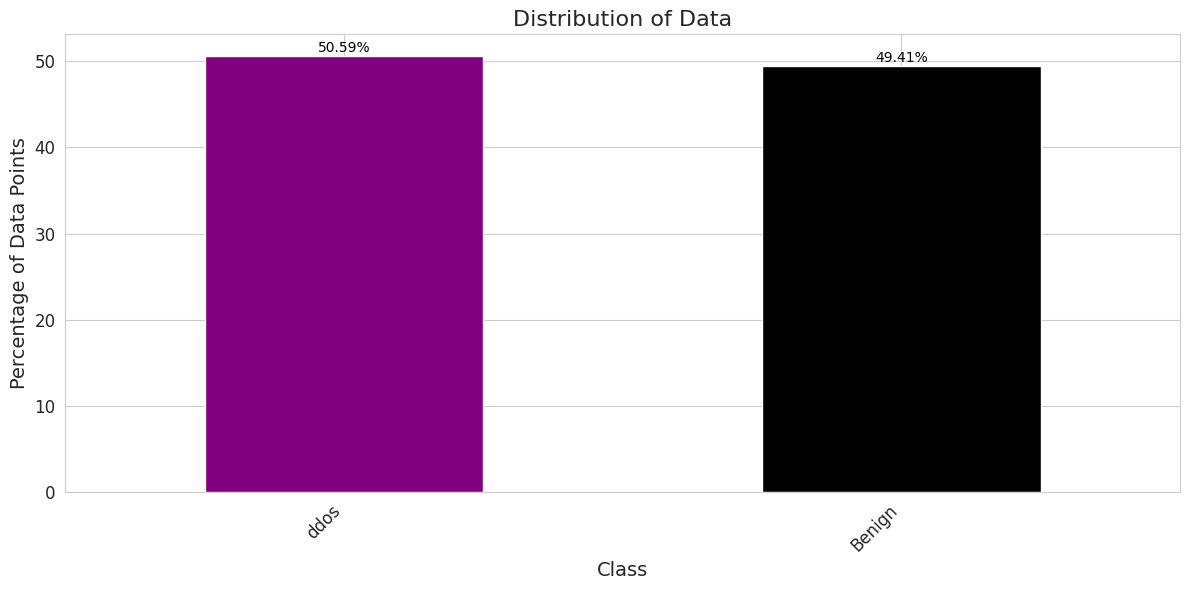

In [ ]:
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")  # Set seaborn style

class_distribution = df['Label'].value_counts(normalize=True) * 100  # Calculate percentages
colors = ['purple', 'black']  # List of colors for bars

barplot = class_distribution.plot(kind='bar', color=colors)

plt.xlabel('Class', fontsize=14)
plt.ylabel('Percentage of Data Points', fontsize=14)
plt.title('Distribution of Data', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate x-axis labels for better readability
plt.yticks(fontsize=12)

# Add percentage labels on top of each bar
for i, value in enumerate(class_distribution):
    barplot.text(i, value + 0.5, f'{value:.2f}%', ha='center', fontsize=10, color='black')

plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

#### Feature Correlation Analysis
Correlation heatmaps identify highly correlated features such as TotLen Fwd Pkts, TotLen Bwd Pkts, Fwd Pkt Len Mean, and Fwd IAT Min, which are then removed. This ensures reduced redundancy and multicollinearity, leaving 32 columns.

In [ ]:
df = df_filtered
styled_df = (
    df.describe()
    .drop("count", axis=0)
    .style.background_gradient(axis=0, cmap="magma")
    .set_properties(**{"text-align": "center"})
    .set_table_styles([{"selector": "th", "props": [("background-color", "k")]}])
    .set_caption("Summary Statistics")
)

styled_df

,Src Port,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Flow IAT Mean,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Max,Bwd IAT Min,Pkt Len Min,Pkt Len Max,Pkt Len Mean,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,ACK Flag Cnt
mean,37081.266681,14638.242458,7.828970,8213385.375572,27.490721,4.727698,1142.314171,2719.337494,292.346538,7.096866,76.238549,301.476446,16.954976,91.918457,1855813.340451,4347199.511690,1445042.915771,7135717.201336,1908309.870164,3360392.808750,1458204.485457,5811047.265772,842838.592717,2626681.117033,216992.831384,7.158929,432.839129,78.276619,0.015375,0.135963,0.111201,0.510809
std,25217.602217,23063.516684,4.205032,24754440.702548,1741.563659,105.853364,55745.670576,152641.167058,392.714051,19.933689,94.314955,442.432940,42.544194,140.848852,8877253.516847,13040123.769240,8782772.806517,24462072.570797,8974341.607896,12348888.840190,8810019.231644,21399866.256902,4036726.830740,9564306.247390,3360262.306273,17.524150,514.765995,94.135292,0.123040,0.342749,0.314381,0.499883
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,443.000000,80.000000,6.000000,1263.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,946.166667,1054.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,50596.000000,80.000000,6.000000,32171.000000,2.000000,1.000000,42.000000,113.000000,40.000000,0.000000,36.000000,100.000000,0.000000,68.000000,18997.000000,30122.000000,47.000000,1272.000000,457.500000,1021.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,101.000000,54.500000,0.000000,0.000000,0.000000,1.000000
75%,56222.000000,38510.000000,6.000000,4156602.500000,4.000000,4.000000,935.000000,358.000000,677.000000,0.000000,142.000000,350.000000,0.000000,114.000000,506941.142857,3885094.000000,1968.000000,141677.000000,51664.333333,105110.000000,90.000000,1917732.000000,385102.583350,969082.000000,328.000000,0.000000,935.000000,143.222222,0.000000,0.000000,0.000000,1.000000
max,65535.000000,65534.000000,17.000000,119999996.000000,309628.000000,21676.000000,9908096.000000,31142967.000000,23360.000000,1472.000000,4262.882353,7300.000000,2065.000000,2185.130435,119988724.000000,119999735.000000,119988724.000000,120000000.000000,119988724.000000,119999869.000000,119988724.000000,119999907.000000,119911492.000000,119911492.000000,119911492.000000,1296.000000,23360.000000,1930.967742,1.000000,1.000000,1.000000,1.000000


In [ ]:
num_cols =  df.select_dtypes(exclude=['object']).columns
fwd_cols = [col for col in num_cols if 'Fwd' in col]
bwd_cols = [col for col in num_cols if 'Bwd' in col]

In [ ]:
def getCorrelatedFeatures(corr):
    correlatedFeatures = set()
    for i in range(len(corr.columns)):
        for j in range(i):
            if abs(corr.iloc[i, j]) > 0.95:
                print(corr.columns[i],corr.iloc[i,j])
                correlatedFeatures.add(corr.columns[i])
    return correlatedFeatures

TotLen Fwd Pkts 0.9993016706274698
Fwd Pkt Len Mean 0.9503456889138319
Fwd IAT Min 0.9745707643425539


{'Fwd IAT Min', 'Fwd Pkt Len Mean', 'TotLen Fwd Pkts'}

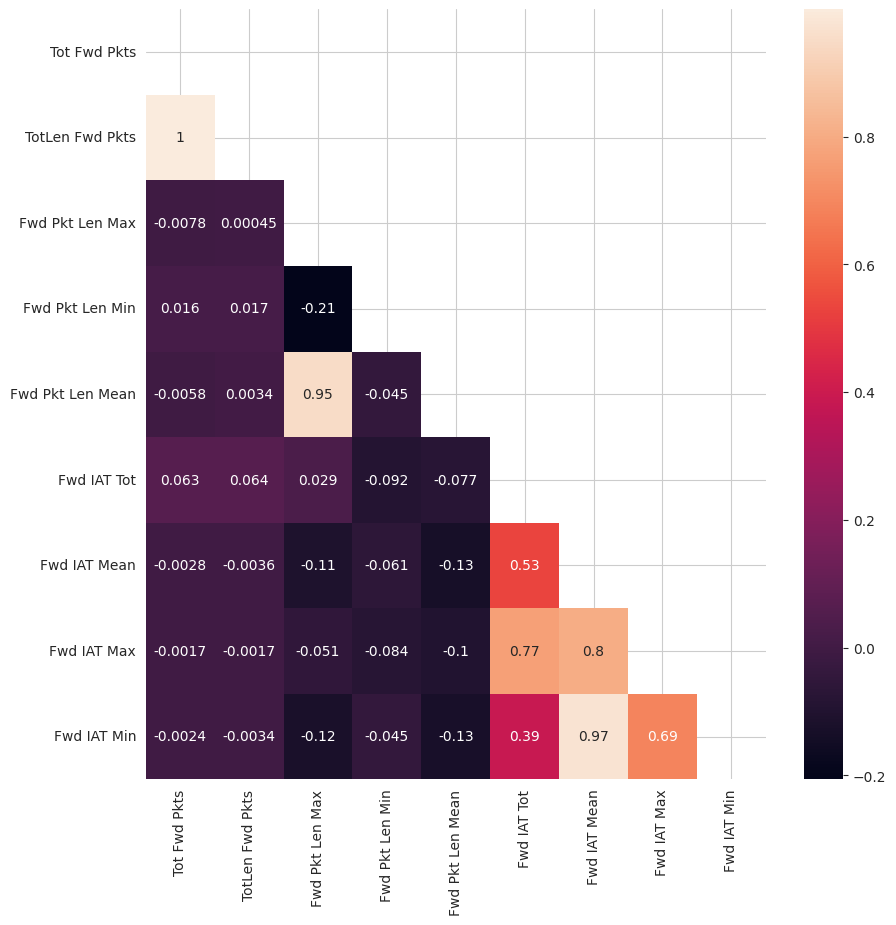

In [ ]:
corr = df[fwd_cols].corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool_))
plt.subplots(figsize=(10,10))
sns.heatmap(corr, annot=True, mask=mask)
correlatedFeatures = set()
correlatedFeatures = correlatedFeatures | getCorrelatedFeatures(corr)
correlatedFeatures

TotLen Bwd Pkts 0.9941316635660596


{'Fwd IAT Min', 'Fwd Pkt Len Mean', 'TotLen Bwd Pkts', 'TotLen Fwd Pkts'}

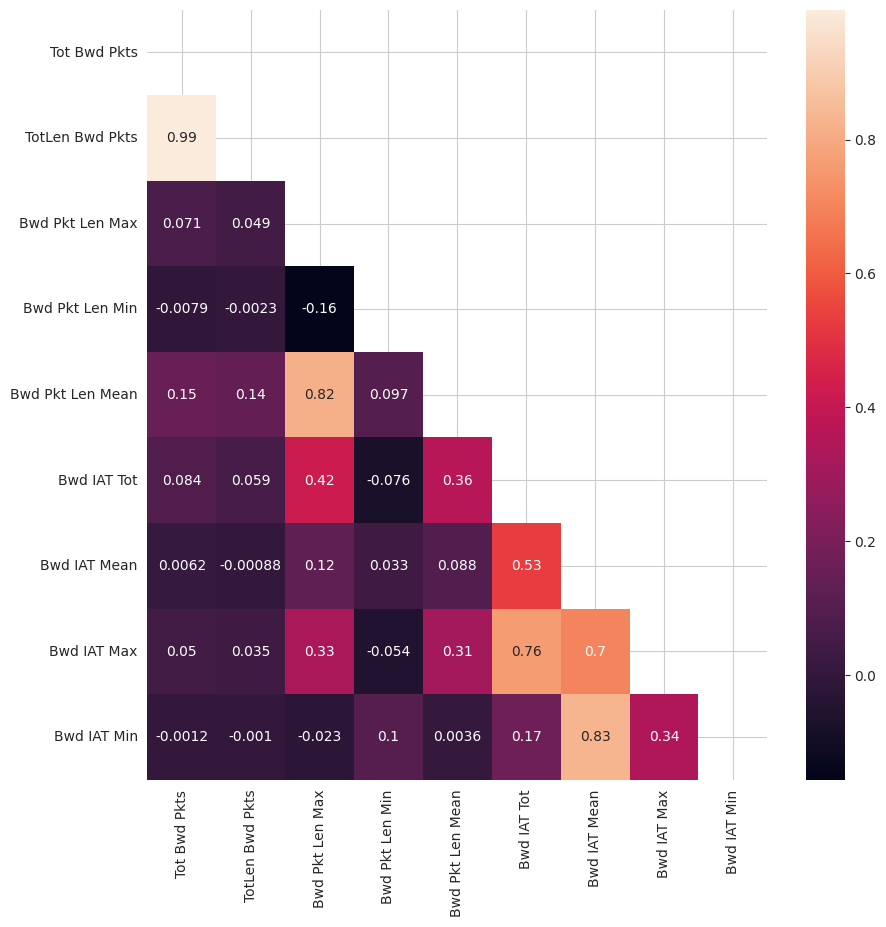

In [ ]:
corr = df[bwd_cols].corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool_))
plt.subplots(figsize=(10,10))
sns.heatmap(corr,annot=True, mask=mask)
correlatedFeatures = correlatedFeatures | getCorrelatedFeatures(corr)
correlatedFeatures

In [ ]:
df.drop(columns=correlatedFeatures, inplace=True)

<Axes: >

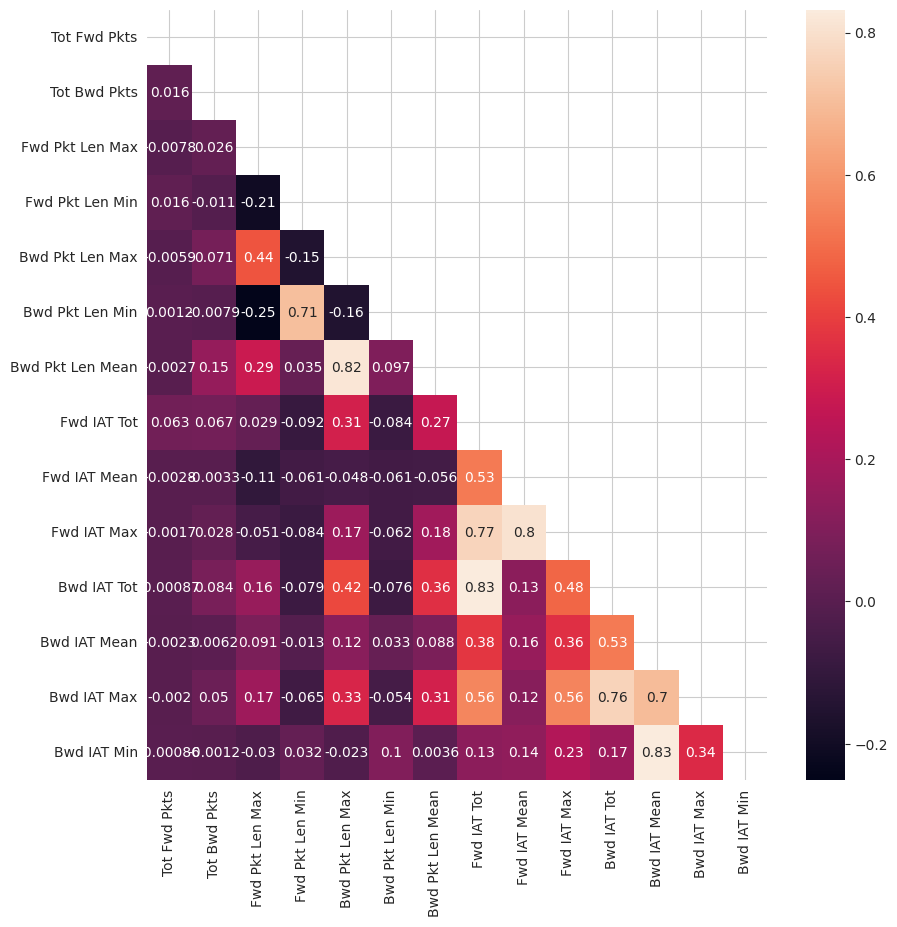

In [ ]:
num_cols = df.select_dtypes(exclude=['object']).columns
cols = [col for col in num_cols if 'Fwd' in col or 'Bwd' in col]
corr = df[cols].corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool_))
plt.subplots(figsize=(10,10))
sns.heatmap(corr, annot=True, mask=mask)

### 3. Feature Selection

In [ ]:
#drop na values and reset index
data_clean = df.dropna().reset_index()
data_clean = data_clean.drop(columns=['index', 'Src Port', 'Dst Port', 'Protocol',"Flow ID",'Src IP', 'Dst IP'])
# label encoding
labelencoder = LabelEncoder()
data_clean['Label'] = labelencoder.fit_transform(data_clean['Label'])
data_clean['Label'].value_counts()

,count
Label,
1,647297
0,632166


In [ ]:
data_clean.shape

(1279463, 26)

In [ ]:
data_clean.columns

Index(['Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Min', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min',
       'Bwd Pkt Len Mean', 'Flow IAT Mean', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Max', 'Bwd IAT Tot',
       'Bwd IAT Mean', 'Bwd IAT Max', 'Bwd IAT Min', 'Pkt Len Min',
       'Pkt Len Max', 'Pkt Len Mean', 'FIN Flag Cnt', 'SYN Flag Cnt',
       'RST Flag Cnt', 'ACK Flag Cnt', 'Label'],
      dtype='object')

In [ ]:
data_clean.head()

,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Flow IAT Mean,Flow IAT Max,...,Bwd IAT Max,Bwd IAT Min,Pkt Len Min,Pkt Len Max,Pkt Len Mean,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,ACK Flag Cnt,Label
0,5032233,3,5,603.0,0.0,972.0,0.0,194.400000,7.188904e+05,5004303.0,...,5004614.0,6.0,0.0,972.0,175.000000,0,1,0,0,1
1,10993127,3,5,408.0,0.0,972.0,0.0,194.400000,1.570447e+06,5990709.0,...,5990709.0,3.0,0.0,972.0,153.333333,0,1,0,0,1
2,479425,3,7,142.0,0.0,1460.0,0.0,671.714286,5.326944e+04,232452.0,...,232857.0,227.0,0.0,1460.0,440.363636,0,1,0,0,1
3,9042123,1,1,0.0,0.0,0.0,0.0,0.000000,9.042123e+06,9042123.0,...,0.0,0.0,0.0,0.0,0.000000,0,0,0,1,1
4,1907579,1,1,0.0,0.0,0.0,0.0,0.000000,1.907579e+06,1907579.0,...,0.0,0.0,0.0,0.0,0.000000,0,0,0,1,1


In [ ]:
# Save to CSV
data_clean.to_csv('/content/drive/MyDrive/CSCE580_Project/data_clean.csv', index=False)

## II. Offline Analysis
Summarize the findings from the offline analysis:
- **Random Forest (RF)** achieved the best performance among tested models.  
- **5f** (five features) were identified as optimal for hardware offload.

### 4. Offline Model Training and Evaluation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Read the CSV file back into a DataFrame
data_clean = pd.read_csv('/content/drive/MyDrive/CSCE580_Project/data_clean.csv')

# Verify it loaded correctly
print(data_clean.shape)
data_clean.head()

(1279463, 26)


,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Flow IAT Mean,Flow IAT Max,...,Bwd IAT Max,Bwd IAT Min,Pkt Len Min,Pkt Len Max,Pkt Len Mean,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,ACK Flag Cnt,Label
0,5032233,3,5,603.0,0.0,972.0,0.0,194.400000,7.188904e+05,5004303.0,...,5004614.0,6.0,0.0,972.0,175.000000,0,1,0,0,1
1,10993127,3,5,408.0,0.0,972.0,0.0,194.400000,1.570447e+06,5990709.0,...,5990709.0,3.0,0.0,972.0,153.333333,0,1,0,0,1
2,479425,3,7,142.0,0.0,1460.0,0.0,671.714286,5.326944e+04,232452.0,...,232857.0,227.0,0.0,1460.0,440.363636,0,1,0,0,1
3,9042123,1,1,0.0,0.0,0.0,0.0,0.000000,9.042123e+06,9042123.0,...,0.0,0.0,0.0,0.0,0.000000,0,0,0,1,1
4,1907579,1,1,0.0,0.0,0.0,0.0,0.000000,1.907579e+06,1907579.0,...,0.0,0.0,0.0,0.0,0.000000,0,0,0,1,1


In [ ]:
# Map importance scores back to feature names
feature_names = ['Flow Duration',
       'Tot Fwd Pkts', 'Tot Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min',
       'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
       'Flow IAT Mean', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot',
       'Fwd IAT Mean', 'Fwd IAT Max', 'Bwd IAT Tot', 'Bwd IAT Mean',
       'Bwd IAT Max', 'Bwd IAT Min', 'Pkt Len Min', 'Pkt Len Max',
       'Pkt Len Mean', 'FIN Flag Cnt', 'SYN Flag Cnt', 'RST Flag Cnt',
       'ACK Flag Cnt']

In [ ]:
data_np = data_clean.to_numpy(dtype="float32")
data_np = data_np[~np.isinf(data_np).any(axis=1)]

#del df

X = data_np[:, 0:25]

enc = OneHotEncoder()

Y = enc.fit_transform(data_np[:,25:]).toarray()

print("X" , np.shape(X))
print("Y" , np.shape(Y))

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data set into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(
    X_scaled, Y, test_size=0.25, random_state=2, shuffle=True)

_features = X.shape[1]
n_classes = Y.shape[1]

X (1279463, 25)
Y (1279463, 2)


#### Deep Learning Models

MLP

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

# Define the model
mlp = MLPClassifier(
    hidden_layer_sizes=(64, 32),  # two hidden layers: 64 and 32 neurons
    activation='relu',            # ReLU activation (common for MLPs)
    solver='adam',                # Adam optimizer
    max_iter=10,                 # number of training epochs
    random_state=42
)

# Train (fit) the model
mlp.fit(X_train, Y_train)

# Predict on test set
Y_pred = mlp.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(Y_test, Y_pred))
print("\nClassification Report:\n", classification_report(Y_test, Y_pred))


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.9722383748194556

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.95      0.97    157931
           1       0.95      0.99      0.97    161935

   micro avg       0.97      0.97      0.97    319866
   macro avg       0.97      0.97      0.97    319866
weighted avg       0.97      0.97      0.97    319866
 samples avg       0.97      0.97      0.97    319866



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.metrics import accuracy_score, classification_report
# Evaluate
print("Accuracy:", accuracy_score(Y_test, Y_pred))
print("\nClassification Report:\n", classification_report(Y_test, Y_pred, digits=4))

# Store metrics
mlp_accuracy = accuracy_score(Y_test, Y_pred)
mlp_report = classification_report(Y_test, Y_pred, digits=4)

Accuracy: 0.9722383748194556


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Classification Report:
               precision    recall  f1-score   support

           0     0.9943    0.9493    0.9713    157931
           1     0.9528    0.9947    0.9733    161935

   micro avg     0.9724    0.9723    0.9723    319866
   macro avg     0.9736    0.9720    0.9723    319866
weighted avg     0.9733    0.9723    0.9723    319866
 samples avg     0.9723    0.9723    0.9723    319866



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


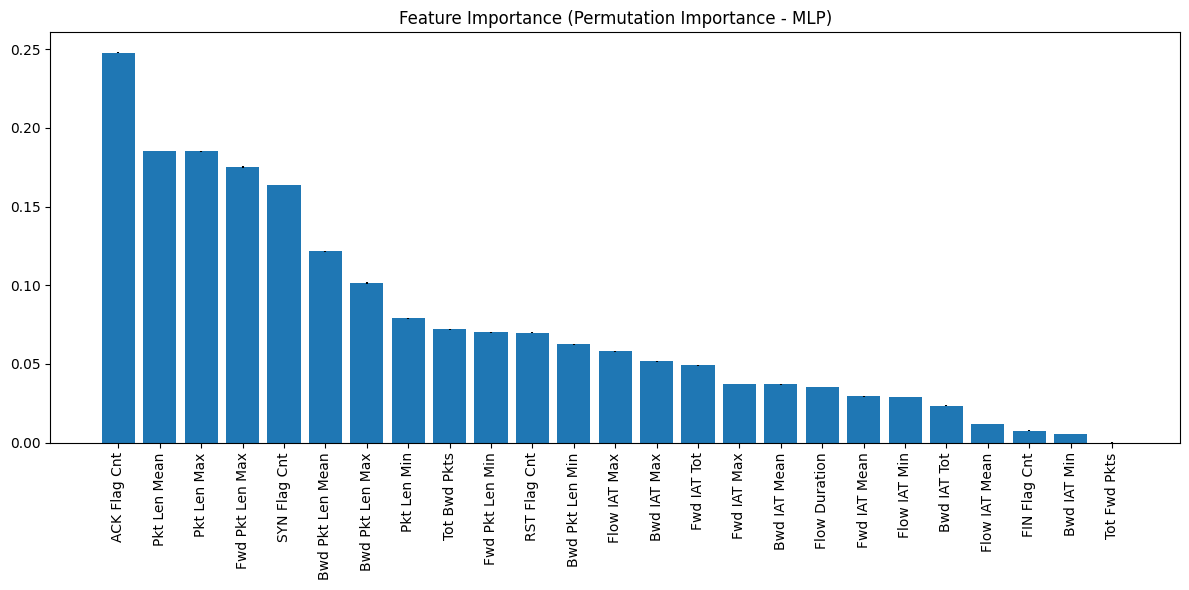

In [ ]:
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

# Compute permutation importance
r = permutation_importance(mlp, X_test, Y_test, n_repeats=3, random_state=42)

importances = r.importances_mean
std = r.importances_std

# Sort features by importance
indices = importances.argsort()[::-1]

# Plot
plt.figure(figsize=(12, 6))
plt.bar(range(len(importances)), importances[indices], yerr=std[indices], align="center")
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.title("Feature Importance (Permutation Importance - MLP)")
plt.tight_layout()
plt.show()


1D-CNN

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, classification_report

# If Y_train/Y_test are one-hot arrays, convert to class labels
# e.g. [1,0] -> 0, [0,1] -> 1
if Y_train.ndim == 2 and Y_train.shape[1] == 2:
    Y_train_bin = np.argmax(Y_train, axis=1)
    Y_test_bin  = np.argmax(Y_test, axis=1)
else:
    Y_train_bin = Y_train
    Y_test_bin  = Y_test

# reshape X as before
X_train_cnn = np.expand_dims(X_train, axis=2)
X_test_cnn  = np.expand_dims(X_test, axis=2)

# model with single sigmoid output (binary)
model = Sequential([
    Conv1D(64, 3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    MaxPooling1D(2),
    Conv1D(32, 3, activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train_cnn, Y_train_bin,
    epochs=5,
    batch_size=128,
    validation_split=0.2,
    verbose=1
)

# predictions -> convert probabilities to class labels 0/1
Y_pred_prob = model.predict(X_test_cnn)
Y_pred = (Y_pred_prob > 0.5).astype(int).ravel()




/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
5998/5998 ━━━━━━━━━━━━━━━━━━━━ 58s 9ms/step - accuracy: 0.8884 - loss: 0.2517 - val_accuracy: 0.9164 - val_loss: 0.1851
Epoch 2/5
5998/5998 ━━━━━━━━━━━━━━━━━━━━ 86s 10ms/step - accuracy: 0.9222 - loss: 0.1832 - val_accuracy: 0.9217 - val_loss: 0.1437
Epoch 3/5
5998/5998 ━━━━━━━━━━━━━━━━━━━━ 57s 10ms/step - accuracy: 0.9676 - loss: 0.1089 - val_accuracy: 0.9692 - val_loss: 0.0977
Epoch 4/5
5998/5998 ━━━━━━━━━━━━━━━━━━━━ 58s 10ms/step - accuracy: 0.9667 - loss: 0.1050 - val_accuracy: 0.9688 - val_loss: 0.0995
Epoch 5/5
5998/5998 ━━━━━━━━━━━━━━━━━━━━ 62s 10ms/step - accuracy: 0.9680 - loss: 0.1004 - val_accuracy: 0.9710 - val_loss: 0.0896
9996/9996 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step


In [ ]:
print("\nAccuracy:", accuracy_score(Y_test_bin, Y_pred))
print(classification_report(Y_test_bin, Y_pred, digits=4))
cnn_accuracy = accuracy_score(Y_test_bin, Y_pred)
cnn_report = classification_report(Y_test_bin, Y_pred, digits=4)


Accuracy: 0.970547041573659
              precision    recall  f1-score   support

           0     0.9911    0.9489    0.9695    157931
           1     0.9521    0.9917    0.9715    161935

    accuracy                         0.9705    319866
   macro avg     0.9716    0.9703    0.9705    319866
weighted avg     0.9714    0.9705    0.9705    319866



#### Tree-based Models

In [ ]:
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier

In [ ]:
data_np = data_clean.to_numpy(dtype="float32")
data_np = data_np[~np.isinf(data_np).any(axis=1)]

#del df

X = data_np[:, 0:25]
Y = data_np[:,25:]

X_train, X_test, y_train, y_test = train_test_split(X,Y,
                                   random_state=42,
                                   test_size=0.25,
                                   shuffle=True)

print("X" , np.shape(X))
print("Y" , np.shape(Y))

X (1279463, 25)
Y (1279463, 1)


In [ ]:
data_np = data_clean.to_numpy(dtype="float32")
data_np = data_np[~np.isinf(data_np).any(axis=1)]

#del df

X = data_np[:, 0:25]

enc = OneHotEncoder()

Y = enc.fit_transform(data_np[:,25:]).toarray()

print("X" , np.shape(X))
print("Y" , np.shape(Y))

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data set into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(
    X_scaled, Y, test_size=0.25, random_state=2, shuffle=True)

X (1279463, 25)
Y (1279463, 2)


Random Forest

In [ ]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# (a) Train and evaluate Random Forest
rf_model = RandomForestClassifier(
    max_depth=20,
    n_estimators=5,
    #max_leaf_nodes=750,
    n_jobs=4,
    random_state=42,
    bootstrap=False
)

rf_model.fit(X_train, Y_train)
Y_pred = rf_model.predict(X_test)

# (b) Feature Importances
importances = rf_model.feature_importances_
feature_importances = (
    pd.DataFrame({'feature': feature_names, 'importance': importances})
    .sort_values('importance', ascending=False)
    .reset_index(drop=True)
)

print("\n(b) Feature Importances")
print(feature_importances)


(b) Feature Importances
             feature  importance
0    Fwd Pkt Len Max    0.179865
1       Flow IAT Min    0.129322
2    Fwd Pkt Len Min    0.118909
3    Bwd Pkt Len Max    0.110748
4      Flow Duration    0.094391
5       ACK Flag Cnt    0.057032
6       Tot Fwd Pkts    0.045434
7        Fwd IAT Max    0.042177
8       Pkt Len Mean    0.037758
9       Fwd IAT Mean    0.032036
10       Fwd IAT Tot    0.031453
11      SYN Flag Cnt    0.018267
12      Tot Bwd Pkts    0.018265
13     Flow IAT Mean    0.018024
14       Bwd IAT Min    0.016636
15      Flow IAT Max    0.012875
16       Pkt Len Max    0.011271
17  Bwd Pkt Len Mean    0.009841
18      Bwd IAT Mean    0.006259
19       Bwd IAT Max    0.003043
20       Pkt Len Min    0.002619
21       Bwd IAT Tot    0.002072
22      FIN Flag Cnt    0.001466
23   Bwd Pkt Len Min    0.000133
24      RST Flag Cnt    0.000105


In [ ]:
accuracy = accuracy_score(Y_test, Y_pred)
print("(a) Model Evaluation")
print(f"Accuracy on test data: {accuracy:.6f}")
print(classification_report(Y_test, Y_pred, digits=4))
rf_accuracy = accuracy_score(Y_test, Y_pred)
rf_report = classification_report(Y_test, Y_pred,digits=4)


(a) Model Evaluation
Accuracy on test data: 0.995439


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0     0.9967    0.9941    0.9954    157931
           1     0.9943    0.9968    0.9955    161935

   micro avg     0.9955    0.9954    0.9955    319866
   macro avg     0.9955    0.9954    0.9955    319866
weighted avg     0.9955    0.9954    0.9955    319866
 samples avg     0.9954    0.9954    0.9954    319866



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


XGBoost

In [ ]:
from xgboost import XGBClassifier

# (A) Rough mapping of your RF params
xgb_model = XGBClassifier(
    n_estimators=5,       # like RF n_estimators
    max_depth=20,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_jobs=4
)

# (B) Recommended starting config (boosting benefits from many trees + learning rate)
# xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=8, random_state=42, n_jobs=4)

xgb_model.fit(X_train, Y_train)
Y_pred = xgb_model.predict(X_test)
print("Accuracy on test data:", accuracy_score(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred, digits=4))
xgb_accuracy = accuracy_score(Y_test, Y_pred)
xgb_report = classification_report(Y_test, Y_pred, digits=4)



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:52:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy on test data: 0.995319915214496
              precision    recall  f1-score   support

           0     0.9965    0.9940    0.9953    157931
           1     0.9941    0.9966    0.9954    161935

   micro avg     0.9953    0.9953    0.9953    319866
   macro avg     0.9953    0.9953    0.9953    319866
weighted avg     0.9953    0.9953    0.9953    319866
 samples avg     0.9953    0.9953    0.9953    319866



Light GBM

In [ ]:
import numpy as np
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report

# If Y_train is one-hot encoded, convert it back to 1D
if len(Y_train.shape) > 1 and Y_train.shape[1] > 1:
    Y_train_1d = np.argmax(Y_train, axis=1)
    Y_test_1d = np.argmax(Y_test, axis=1)
else:
    Y_train_1d = Y_train
    Y_test_1d = Y_test

# (A) Rough mapping
lgb_model = LGBMClassifier(
    n_estimators=5,
    max_depth=20,
    random_state=42,
    n_jobs=4,
)

lgb_model.fit(X_train, Y_train_1d)
Y_pred = lgb_model.predict(X_test)
print("Accuracy on test data:", accuracy_score(Y_test_1d, Y_pred))
print(classification_report(Y_test_1d, Y_pred,digits=4))
lgb_accuracy = accuracy_score(Y_test_1d, Y_pred)
lgb_report = classification_report(Y_test_1d, Y_pred,digits=4)

[LightGBM] [Info] Number of positive: 485362, number of negative: 474235
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.115123 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4984
[LightGBM] [Info] Number of data points in the train set: 959597, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505798 -> initscore=0.023192
[LightGBM] [Info] Start training from score 0.023192


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Accuracy on test data: 0.9907648827946702
              precision    recall  f1-score   support

           0     0.9921    0.9892    0.9906    157931
           1     0.9895    0.9923    0.9909    161935

    accuracy                         0.9908    319866
   macro avg     0.9908    0.9907    0.9908    319866
weighted avg     0.9908    0.9908    0.9908    319866



CatBoost

In [ ]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.4 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report

# CatBoost often performs well with default params.
# (A) Rough mapping
cat_model = CatBoostClassifier(
    iterations=100,     # analogous to n_estimators
    depth=6,          # catboost uses 'depth' instead of max_depth
    random_seed=42,
    verbose=False
)

# (B) Recommended
# cat_model = CatBoostClassifier(iterations=1000, learning_rate=0.03, depth=6, random_seed=42, verbose=100)

# If you have categorical feature indices, pass them like: cat_features = [0, 3, 5]
# cat_model.fit(X_train, Y_train, cat_features=cat_features)

cat_model.fit(X_train, Y_train_1d)
Y_pred = cat_model.predict(X_test)

# Note: catboost predict returns np.array of shape (n,) for labels
print("Accuracy on test data:", accuracy_score(Y_test_1d, Y_pred))  # Fixed: Y_test_1d instead of Y_train_1d
print(classification_report(Y_test_1d, Y_pred,digits=4))
catb_accuracy = accuracy_score(Y_test_1d, Y_pred)
catb_report = classification_report(Y_test_1d, Y_pred,digits=4)

Accuracy on test data: 0.9952011154671019
              precision    recall  f1-score   support

           0     0.9960    0.9943    0.9951    157931
           1     0.9944    0.9961    0.9953    161935

    accuracy                         0.9952    319866
   macro avg     0.9952    0.9952    0.9952    319866
weighted avg     0.9952    0.9952    0.9952    319866



#### Linear Models

Support Vector Machine (SVM)

In [ ]:
# SVM cell
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.inspection import permutation_importance
import pandas as pd
import numpy as np

# Debug information
print(f"X_train shape: {X_train.shape}")
print(f"Original Y_train shape: {Y_train.shape}")
print(f"Y_train_1d shape: {Y_train_1d.shape}")

# The correct way to convert from one-hot to 1D labels
if len(Y_train.shape) == 2 and Y_train.shape[1] > 1:
    # If Y_train is one-hot encoded, use argmax to get class labels
    Y_train_correct = np.argmax(Y_train, axis=1)
    Y_test_correct = np.argmax(Y_test, axis=1)
else:
    # If it's already 1D or has other issues
    Y_train_correct = Y_train.reshape(-1) if len(Y_train.shape) > 1 else Y_train
    Y_test_correct = Y_test.reshape(-1) if len(Y_test.shape) > 1 else Y_test

print(f"Corrected Y_train shape: {Y_train_correct.shape}")
print(f"Corrected Y_test shape: {Y_test_correct.shape}")

# Verify the samples match
print(f"Samples check - X_train: {X_train.shape[0]}, Y_train: {Y_train_correct.shape[0]}")

# (a) Train & evaluate SVM
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
     ('svc', SVC(
        kernel='rbf',
        C=1.0,
        random_state=42,
        cache_size=1000,  # Increase cache size
        max_iter=1000,    # Limit iterations
        tol=0.01          # Increase tolerance for faster convergence
    ))
])

svm_pipeline.fit(X_train, Y_train_correct)
Y_pred_svm = svm_pipeline.predict(X_test)

print("(a) SVM Model Evaluation")
svm_acc = accuracy_score(Y_test_correct, Y_pred_svm)
print(f"Accuracy on test data: {svm_acc:.4f}")
print(classification_report(Y_test_correct, Y_pred_svm, digits=4))
svm_accuracy = accuracy_score(Y_test_correct, Y_pred_svm)
svm_report = classification_report(Y_test_correct, Y_pred_svm, digits=4)

X_train shape: (959597, 25)
Original Y_train shape: (959597, 2)
Y_train_1d shape: (959597,)
Corrected Y_train shape: (959597,)
Corrected Y_test shape: (319866,)
Samples check - X_train: 959597, Y_train: 959597


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


(a) SVM Model Evaluation
Accuracy on test data: 0.3641
              precision    recall  f1-score   support

           0     0.2600    0.1560    0.1950    157931
           1     0.4079    0.5671    0.4745    161935

    accuracy                         0.3641    319866
   macro avg     0.3340    0.3616    0.3348    319866
weighted avg     0.3349    0.3641    0.3365    319866



#### Probabilistic Models

Naive Bayes

In [ ]:
# Naive Bayes cell
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.inspection import permutation_importance
import pandas as pd
import numpy as np

# Use the corrected target variables (same as what worked for SVM)
# If you already defined Y_train_correct and Y_test_correct for SVM, use those
# Otherwise, define them here:

# If Y_train is one-hot encoded (most likely case)
if len(Y_train.shape) == 2 and Y_train.shape[1] > 1:
    Y_train_correct = np.argmax(Y_train, axis=1)
    Y_test_correct = np.argmax(Y_test, axis=1)
else:
    Y_train_correct = Y_train.reshape(-1)
    Y_test_correct = Y_test.reshape(-1)

print(f"X_train shape: {X_train.shape}")
print(f"Y_train_correct shape: {Y_train_correct.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_test_correct shape: {Y_test_correct.shape}")

# (a) Train & evaluate GaussianNB
# NB often benefits from scaling but not strictly required; include scaler for consistency.
nb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('gnb', GaussianNB())
])

nb_pipeline.fit(X_train, Y_train_correct)
Y_pred_nb = nb_pipeline.predict(X_test)

print("(a) GaussianNB Model Evaluation")
nb_acc = accuracy_score(Y_test_correct, Y_pred_nb)
print(f"Accuracy on test data: {nb_acc:.4f}")
print(classification_report(Y_test_correct, Y_pred_nb, digits=4))
nb_accuracy = accuracy_score(Y_test_correct, Y_pred_nb)
nb_report = classification_report(Y_test_correct, Y_pred_nb, digits=4)

X_train shape: (959597, 25)
Y_train_correct shape: (959597,)
X_test shape: (319866, 25)
Y_test_correct shape: (319866,)
(a) GaussianNB Model Evaluation
Accuracy on test data: 0.7494
              precision    recall  f1-score   support

           0     0.9327    0.5308    0.6766    157931
           1     0.6778    0.9627    0.7955    161935

    accuracy                         0.7494    319866
   macro avg     0.8053    0.7467    0.7360    319866
weighted avg     0.8037    0.7494    0.7368    319866



#### Neightbor-based Models

Kth Nearest Neighbor

In [ ]:
# kNN cell
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.inspection import permutation_importance
import pandas as pd
import numpy as np

# Use the corrected target variables
# If you already defined Y_train_correct and Y_test_correct, use those
# Otherwise, define them here:

# If Y_train is one-hot encoded (most likely case)
if len(Y_train.shape) == 2 and Y_train.shape[1] > 1:
    Y_train_correct = np.argmax(Y_train, axis=1)
    Y_test_correct = np.argmax(Y_test, axis=1)
else:
    Y_train_correct = Y_train.reshape(-1)
    Y_test_correct = Y_test.reshape(-1)

print(f"X_train shape: {X_train.shape}")
print(f"Y_train_correct shape: {Y_train_correct.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_test_correct shape: {Y_test_correct.shape}")

# (a) Train & evaluate kNN
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=5, algorithm='kd_tree', metric='euclidean', n_jobs=-1))
])
knn_pipeline.fit(X_train, Y_train_correct)

Y_pred_knn = knn_pipeline.predict(X_test)

print("(a) kNN Model Evaluation")
knn_acc = accuracy_score(Y_test_correct, Y_pred_knn)
print(f"Accuracy on test data: {knn_acc:.4f}")
print(classification_report(Y_test_correct, Y_pred_knn, digits=4))
knn_accuracy = accuracy_score(Y_test_correct, Y_pred_knn)
knn_report = classification_report(Y_test_correct, Y_pred_knn, digits=4)

X_train shape: (959597, 25)
Y_train_correct shape: (959597,)
X_test shape: (319866, 25)
Y_test_correct shape: (319866,)
(a) kNN Model Evaluation
Accuracy on test data: 0.9951
              precision    recall  f1-score   support

           0     0.9964    0.9937    0.9950    157931
           1     0.9939    0.9965    0.9952    161935

    accuracy                         0.9951    319866
   macro avg     0.9951    0.9951    0.9951    319866
weighted avg     0.9951    0.9951    0.9951    319866



### 5. Model Selection for Deployment

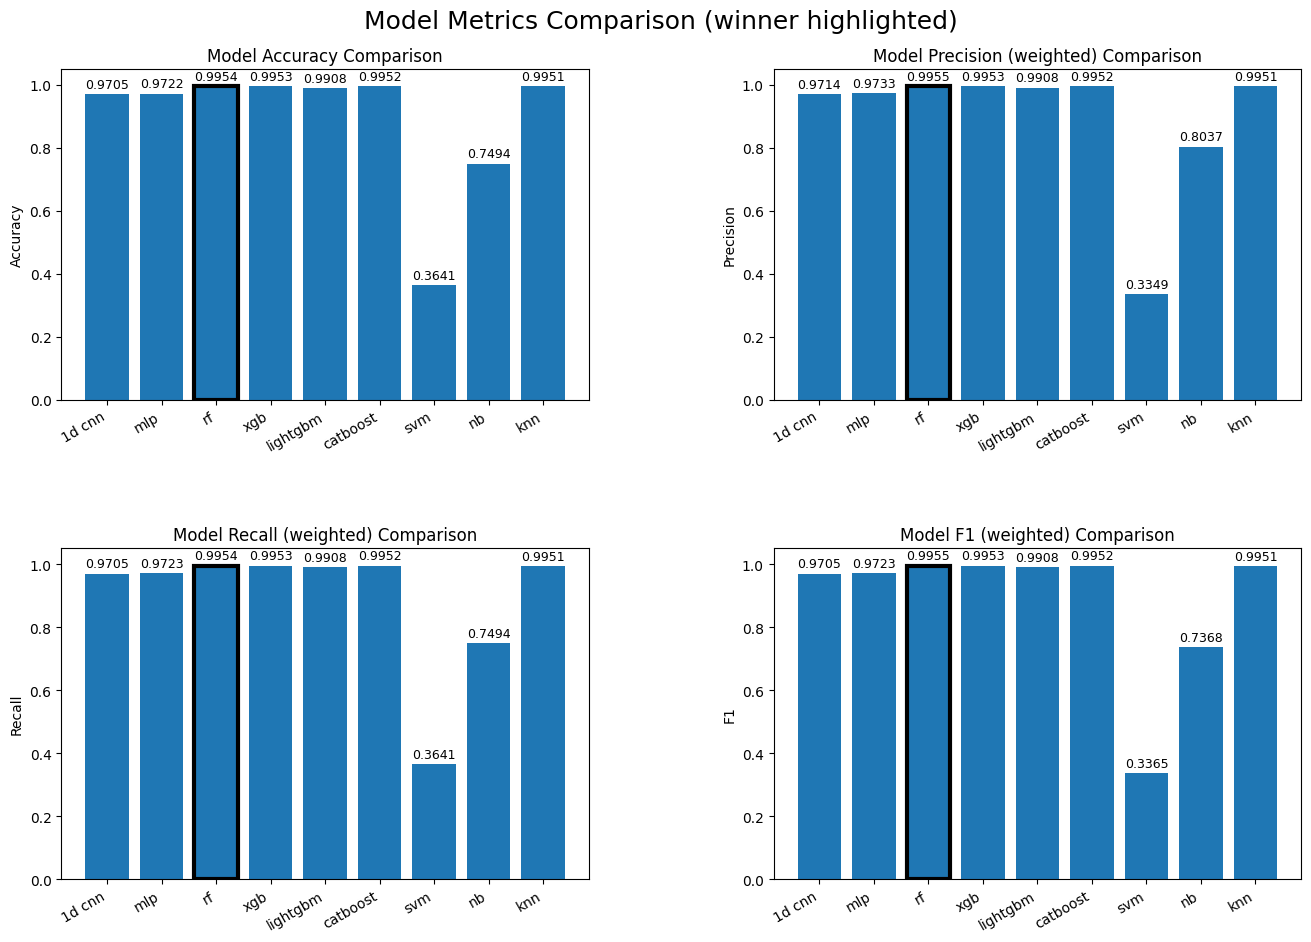


Summary table (rounded to 4 decimals):
          accuracy  precision_weighted  recall_weighted  f1_weighted
model                                                               
1d cnn      0.9705              0.9714           0.9705       0.9705
mlp         0.9722              0.9733           0.9723       0.9723
rf          0.9954              0.9955           0.9954       0.9955
xgb         0.9953              0.9953           0.9953       0.9953
lightgbm    0.9908              0.9908           0.9908       0.9908
catboost    0.9952              0.9952           0.9952       0.9952
svm         0.3641              0.3349           0.3641       0.3365
nb          0.7494              0.8037           0.7494       0.7368
knn         0.9951              0.9951           0.9951       0.9951


In [ ]:
# Plot model metrics using existing variables (accuracy vars and/or classification_report strings)
# Paste this into the same notebook that has variables like mlp_accuracy, mlp_report, knn_report, etc.

import re
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- Model -> (accuracy_varname, report_varname) mapping ---
models_info = {
    "1d cnn":    ("cnn_accuracy", "cnn_report"),
    "mlp":       ("mlp_accuracy", "mlp_report"),
    "rf":        ("rf_accuracy", "rf_report"),
    "xgb":       ("xgb_accuracy", "xgb_report"),
    "lightgbm":  ("lgb_accuracy", "lgb_report"),
    "catboost":  ("catb_accuracy", "catb_report"),
    "svm":       ("svm_accuracy", "svm_report"),
    "nb":        ("nb_accuracy", "nb_report"),
    "knn":       ("knn_accuracy", "knn_report"),
}

def parse_classification_report(report):
    """Return dict with weighted precision/recall/f1 from a classification_report (string or dict)."""
    if report is None:
        return {"precision": None, "recall": None, "f1": None}
    if isinstance(report, dict):
        wa = report.get("weighted avg") or report.get("weighted_avg") or report.get("weighted")
        if isinstance(wa, dict):
            return {
                "precision": float(wa.get("precision", np.nan)),
                "recall": float(wa.get("recall", np.nan)),
                "f1": float(wa.get("f1-score", wa.get("f1", np.nan))),
            }
    if isinstance(report, str):
        # usual line: "weighted avg     0.9951    0.9951    0.9951    319866"
        m = re.search(r"weighted\s*avg[^\n\r]*\s([0-9]*\.[0-9]+)\s+([0-9]*\.[0-9]+)\s+([0-9]*\.[0-9]+)", report, re.IGNORECASE)
        if m:
            return {"precision": float(m.group(1)), "recall": float(m.group(2)), "f1": float(m.group(3))}
        # alternative attempt: look for a "weighted avg" line then floats next line
        m2 = re.search(r"weighted\s*avg[^\n\r]*\n?\s*([0-9]*\.[0-9]+)\s+([0-9]*\.[0-9]+)\s+([0-9]*\.[0-9]+)", report, re.IGNORECASE)
        if m2:
            return {"precision": float(m2.group(1)), "recall": float(m2.group(2)), "f1": float(m2.group(3))}
    return {"precision": None, "recall": None, "f1": None}

def extract_accuracy(globals_, acc_name, rep_name):
    """Try direct accuracy var, else parse report for 'Accuracy on test data' or 'accuracy' line."""
    if acc_name in globals_ and globals_[acc_name] is not None:
        try:
            return float(globals_[acc_name])
        except Exception:
            pass
    if rep_name in globals_ and globals_[rep_name] is not None:
        rep = globals_[rep_name]
        if isinstance(rep, dict) and "accuracy" in rep:
            try:
                return float(rep["accuracy"])
            except Exception:
                pass
        if isinstance(rep, str):
            m = re.search(r"Accuracy on test data[:\s]+([0-9]*\.[0-9]+)", rep, re.IGNORECASE)
            if m:
                return float(m.group(1))
            m2 = re.search(r"^\s*accuracy\s+([0-9]*\.[0-9]+)", rep, re.MULTILINE | re.IGNORECASE)
            if m2:
                return float(m2.group(1))
    return None

# Collect metrics
g = globals()
labels, accuracies, precisions, recalls, f1s = [], [], [], [], []

for label, (acc_var, rep_var) in models_info.items():
    acc = extract_accuracy(g, acc_var, rep_var)
    rep = g.get(rep_var, None)
    parsed = parse_classification_report(rep)
    p = parsed.get("precision")
    r = parsed.get("recall")
    f1 = parsed.get("f1")
    # If we have none of the metrics, skip
    if acc is None and (p is None or r is None or f1 is None):
        warnings.warn(f"Skipping '{label}' — couldn't find {acc_var} or weighted metrics in {rep_var}.")
        continue
    labels.append(label)
    accuracies.append(acc if acc is not None else np.nan)
    precisions.append(p if p is not None else np.nan)
    recalls.append(r if r is not None else np.nan)
    f1s.append(f1 if f1 is not None else np.nan)

if not labels:
    raise RuntimeError("No models found with usable metrics. Ensure variables like 'knn_report' or 'knn_accuracy' exist in the namespace.")

# to numpy arrays
accuracies = np.array(accuracies, dtype=float)
precisions = np.array(precisions, dtype=float)
recalls = np.array(recalls, dtype=float)
f1s = np.array(f1s, dtype=float)

# plotting helper
def plot_metric(ax, values, title, ylabel):
    x = np.arange(len(labels))
    bars = ax.bar(x, values)  # default matplotlib colors (no explicit color setting)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=30, ha='right')
    ax.set_ylim(0.0, 1.05)
    ax.set_ylabel(ylabel)
    ax.set_title(title, fontsize=12)
    # highlight winner (ignore NaN)
    if not np.all(np.isnan(values)):
        winner = int(np.nanargmax(values))
        bars[winner].set_edgecolor('black')
        bars[winner].set_linewidth(3)
    # annotate bars
    for i, v in enumerate(values):
        if np.isnan(v):
            txt = "n/a"
            y = 0.02
        else:
            txt = f"{v:.4f}"
            y = v + 0.01
        ax.text(i, y, txt, ha='center', va='bottom', fontsize=9)
    return bars

fig, axs = plt.subplots(2, 2, figsize=(16, 10))
plt.subplots_adjust(hspace=0.45, wspace=0.35, top=0.92)

plot_metric(axs[0, 0], accuracies, "Model Accuracy Comparison", "Accuracy")
plot_metric(axs[0, 1], precisions, "Model Precision (weighted) Comparison", "Precision")
plot_metric(axs[1, 0], recalls, "Model Recall (weighted) Comparison", "Recall")
plot_metric(axs[1, 1], f1s, "Model F1 (weighted) Comparison", "F1")

fig.suptitle("Model Metrics Comparison (winner highlighted)", fontsize=18, y=0.98)
plt.show()

# Summary table
summary = pd.DataFrame({
    "model": labels,
    "accuracy": np.round(accuracies, 4),
    "precision_weighted": np.round(precisions, 4),
    "recall_weighted": np.round(recalls, 4),
    "f1_weighted": np.round(f1s, 4),
}).set_index("model")

print("\nSummary table (rounded to 4 decimals):")
print(summary.to_string())

# End of snippet


### 6. Feature Reduction for Hardware Offload

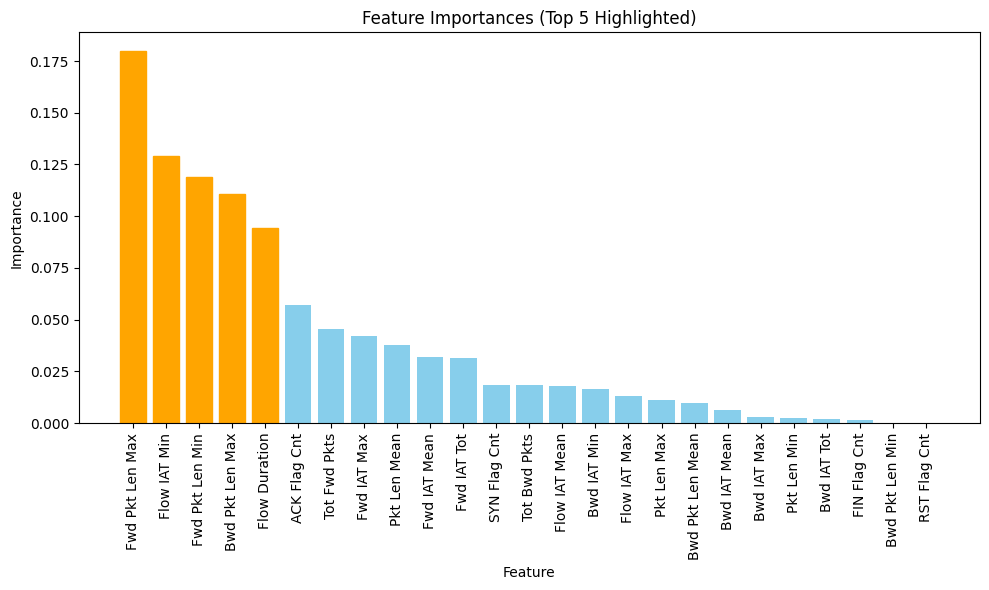

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Create the dataframe
data = {
    "Feature": [
        "Fwd Pkt Len Max", "Flow IAT Min", "Fwd Pkt Len Min", "Bwd Pkt Len Max", "Flow Duration",
        "ACK Flag Cnt", "Tot Fwd Pkts", "Fwd IAT Max", "Pkt Len Mean", "Fwd IAT Mean",
        "Fwd IAT Tot", "SYN Flag Cnt", "Tot Bwd Pkts", "Flow IAT Mean", "Bwd IAT Min",
        "Flow IAT Max", "Pkt Len Max", "Bwd Pkt Len Mean", "Bwd IAT Mean", "Bwd IAT Max",
        "Pkt Len Min", "Bwd IAT Tot", "FIN Flag Cnt", "Bwd Pkt Len Min", "RST Flag Cnt"
    ],
    "Importance": [
        0.179865, 0.129322, 0.118909, 0.110748, 0.094391,
        0.057032, 0.045434, 0.042177, 0.037758, 0.032036,
        0.031453, 0.018267, 0.018265, 0.018024, 0.016636,
        0.012875, 0.011271, 0.009841, 0.006259, 0.003043,
        0.002619, 0.002072, 0.001466, 0.000133, 0.000105
    ]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Sort by importance descending
df_sorted = df.sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(10,6))
bars = plt.bar(df_sorted["Feature"], df_sorted["Importance"], color="skyblue")

# Highlight top 5
for i in range(5):
    bars[i].set_color("orange")

# Customize plot
plt.xticks(rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importances (Top 5 Highlighted)")
plt.tight_layout()

# Show the plot
plt.show()


## III. Integration with P4-DPDK Pipeline

Link to processed pcap file from the dataset: http://cicresearch.ca/CICDataset/CIC-IDS-2017/Dataset/CIC-IDS-2017/PCAPs/ </br>
The pcap file in this link are processed in a separate notebook to extract the per-flow features and record them in testing and training csv files with labels -
[link to pcap-preprocessing notebook](./pcap-preprocessing.ipynb) </br>
[train_data.csv](../data/train_data_CIC.csv) </br>
[test_data.csv](../data/test_data_CIC.csv) </br>

In [6]:
pip install scapy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import numpy as np
import pandas as pd
import csv
import json
import argparse
from sklearn.metrics import accuracy_score
import graphviz
from sklearn.tree import export_graphviz
from imblearn.over_sampling import SMOTE
from sklearn import tree
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
import matplotlib
matplotlib.rcParams['font.family'] = 'DejaVu Sans'
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, classification_report
from sklearn.metrics import classification_report
pd.options.mode.chained_assignment = None
from sklearn.metrics import confusion_matrix
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [ ]:
class_numbers = ['BENIGN', 'DDoS']
features = ['Min differential Packet Length', 'Max differential Packet Length', 'IAT min', 'IAT max', 'Packet Length Total']

In [ ]:
# Function to get scores of the model under test
def get_scores(classes, depth, n_tree, feats, max_leaf, X_train, y_train, X_test, y_test):

    model = RandomForestClassifier(max_depth=depth, n_estimators = n_tree, max_leaf_nodes=max_leaf, n_jobs=4,
                                    random_state=42, bootstrap=False, class_weight='balanced')
    model.fit(X_train[features], y_train)
    y_pred = model.predict(X_test[features])
    class_report = classification_report(y_test, y_pred, target_names=class_numbers, output_dict = True)
    macro_score = class_report['macro avg']['f1-score']
    weighted_score = class_report['weighted avg']['f1-score']

    return model, class_report, macro_score, weighted_score, y_pred

# Function to save final model for later analysis
def save_model(model, filename):
    pickle.dump(model, open(filename, 'wb'))

# Function to separate data into features and labels
def extract_x_y(Dataset, classes, features):
    Dataset = Dataset[Dataset["Label"].isin(class_numbers)]
    X = Dataset[features]
    y = Dataset['Label'].replace(class_numbers, range(len(class_numbers)))
    return X, y

# Function to Fit model based on optimal values of depth and number of estimators and use it
# to compute feature importance for all the features.
def get_feature_importance(depth, n_tree, max_leaf, X_train, y_train):
    rf_opt = RandomForestClassifier(max_depth = depth, n_estimators = n_tree,
                                    max_leaf_nodes=max_leaf, random_state=42, bootstrap=False, class_weight='balanced')
    rf_opt.fit(X_train, y_train)
    feature_importance = pd.DataFrame(rf_opt.feature_importances_)
    feature_importance.index = X_train.columns
    feature_importance = feature_importance.sort_values(by=list(feature_importance.columns),axis=0,ascending=False)

    return feature_importance

# Function to Fit model based on optimal values of depth and number of estimators and feature importance
# to find the fewest possible features to exceed the previously attained score with all selected features
def get_fewest_features(importance):
    sorted_feature_names = importance.index
    features = []
    for f in range(1,len(sorted_feature_names)+1):
        features.append(sorted_feature_names[0:f])
    return features

# Function to analyze different combinations of model hyperparameters
def analyze_models(class_numbers, model_type, depths, n_trees, X_train, y_train, X_test, y_test, max_leaf, filename_out):
    # Create a list to hold the results
    results = []

    if model_type == 'RF':
        # FOR EACH (depth, n_tree, feat)
        for depth in depths:
            for n_tree in n_trees:
                # get feature orders to use
                importance = get_feature_importance(depth, n_tree, max_leaf, X_train, y_train)
                print(importance)
                plt.figure(figsize=(10, 6))
                plt.barh(importance.index, importance[0])
                plt.gca().invert_yaxis()
                plt.title("Feature Importance in Random Forest")
                plt.xlabel("Importance Score")
                plt.ylabel("Feature")
                plt.tight_layout()
                plt.show()
                m_feats = get_fewest_features(importance)
                for feats in m_feats:
                    # Get the scores with the given (depth, n_tree, feat)
                    model, c_report, macro_f1, weight_f1, y_pred = get_scores(
                        class_numbers, depth, n_tree, feats, max_leaf, X_train, y_train, X_test, y_test
                    )

                    # Append results as a dictionary
                    results.append({
                        "depth": depth,
                        "n_tree": n_tree,
                        "max_leaf": max_leaf,
                        "n_feat": len(feats),
                        "macro": macro_f1,
                        "weighted": weight_f1,
                        "features": list(feats),  # Convert features to a list
                        "c_report": c_report  # Add the classification report
                    })

    # Write the results to a .json file
    with open(filename_out, mode="w") as file:
        json.dump(results, file, indent=4)  # Pretty-print JSON with an indentation of 4 spaces

    print("Analysis Complete. Check output file.")
    return []

def find_best_parameters(json_file, metric="weighted"):
    # Load the JSON file
    with open(json_file, 'r') as file:
        data = json.load(file)

    # Check if data is empty
    if not data:
        print("The JSON file is empty!")
        return None

    # Find the best configuration based on the specified metric
    best_config = max(data, key=lambda x: x[metric])

    # Print summary including depth
    print("Best Configuration:")
    print(f"Depth: {best_config['depth']}")
    print(f"N_tree: {best_config['n_tree']}")
    print(f"Max_leaf: {best_config['max_leaf']}")
    print(f"Number of Features: {best_config['n_feat']}")
    print(f"{metric.capitalize()} F1 Score: {best_config[metric]}")
    print(f"Features: {best_config['features']}")
    print(f"Classification Report: {best_config['c_report']}")

    return best_config

def evaluate_model_overfitting(model, X_train, y_train, X_test, y_test):
    # Evaluate training performance
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_report = classification_report(y_train, y_train_pred, output_dict=True)

    # Evaluate test performance
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_report = classification_report(y_test, y_test_pred, output_dict=True)

    # Analyze performance difference
    performance_diff = train_accuracy - test_accuracy
    if performance_diff > 0.1:  # Large gap between train and test
        evaluation = "The model is likely overfitting. Try regularization or simplifying the model."
    elif train_accuracy < 0.6 and test_accuracy < 0.6:  # Both low accuracies
        evaluation = "The model is likely underfitting. Try increasing complexity or adding more features."
    else:
        evaluation = "The model has a good balance between training and testing performance."

    # Print and return results
    results = {
        "Train Accuracy": train_accuracy,
        "Test Accuracy": test_accuracy,
        "Train Report": train_report,
        "Test Report": test_report,
        "Evaluation": evaluation
    }

    print(f"Train Accuracy: {train_accuracy}")
    print(f"Test Accuracy: {test_accuracy}")
    print(f"Performance Difference: {performance_diff}")
    print(f"Evaluation: {evaluation}")

    return results

# --- Plot Confusion Matrix as a Heatmap ---

def plot_confusion_matrix(conf_matrix, labels, save_path="confusion_matrix.png"):
    labels = ['Discord', 'WhatsApp', 'Signal', 'Telegram', 'Messenger', 'Teams']

    # Scale accuracy values to percentages
    conf_matrix = np.round(conf_matrix * 100, 2)

    plt.figure(figsize=(12, 10))
    plt.rcParams["font.family"] = "Quattrocento Sans"

    heatmap = sns.heatmap(
        conf_matrix,
        annot=True,
        fmt=".0f",
        cmap="Blues",
        xticklabels=labels,
        yticklabels=labels,
        annot_kws={'size': 22}
    )

    plt.xlabel("Predicted (Classes)", fontsize=22)
    plt.ylabel("Actual (Classes)", fontsize=22)

    # Set tick label font sizes and align x labels to center under ticks
    plt.xticks(rotation=30, ha='center', fontsize=22)
    plt.yticks(rotation=0, fontsize=22)

    # Colorbar customization
    colorbar = heatmap.collections[0].colorbar
    colorbar.set_ticks([0, 20, 40, 60, 80, 100])
    colorbar.set_ticklabels(["0", "20", "40", "60", "80", "100"])
    colorbar.ax.tick_params(labelsize=22)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()


def plot_metrics_bar_chart(accuracy, precision, recall, weighted_f1, macro_f1, save_path="metrics_plot.png"):
    metrics = ["Accuracy", "Precision", "Recall", "Weighted F1", "Macro F1"]
    scores = [accuracy, precision, recall, weighted_f1, macro_f1]

    font_size = 44  # Set the desired font size for all elements

    plt.figure(figsize=(24, 12))  # Increase width for better spacing
    bars = plt.bar(metrics, scores, color=["navy", "darkblue", "royalblue", "steelblue", "skyblue"])
    plt.ylim(60, 100)

    # Adding text annotations with specified font properties
    for bar, score in zip(bars, scores):
        plt.text(bar.get_x() + bar.get_width()/2, score + 1, f"{score:.1f}",
                 ha="center", fontsize=font_size, fontfamily="Quattrocento Sans")

    # Apply font size to axis labels, title, and ticks
    plt.ylabel("Score [%]", fontsize=font_size, fontfamily="Quattrocento Sans")
    plt.xticks(fontsize=font_size, fontfamily="Quattrocento Sans")  # Rotate for spacing
    plt.yticks(fontsize=font_size, fontfamily="Quattrocento Sans")
    plt.title("Model Performance Metrics", fontsize=font_size, fontfamily="Quattrocento Sans")

    # Save the image
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

# Define ANSI escape code for #8F493F (approximate as a terminal color)
COLOR_CODE = "\033[38;2;143;73;63m"  # RGB escape sequence for the desired color
RESET_CODE = "\033[0m"  # Reset color

# --- Function to Compute TP, TN, FP, FN for Each Class ---
def compute_per_class_metrics(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    num_classes = conf_matrix.shape[0]  # Number of classes
    TP = np.diag(conf_matrix)  # True Positives
    FP = conf_matrix.sum(axis=0) - TP  # False Positives
    FN = conf_matrix.sum(axis=1) - TP  # False Negatives
    TN = conf_matrix.sum() - (FP + FN + TP)  # True Negatives

    return TP, TN, FP, FN

# --- Function to Display Per-Class Metrics with Color ---
def display_per_class_metrics(y_true, y_pred):
    labels = sorted(np.unique(y_true))  # Extract unique class labels
    TP, TN, FP, FN = compute_per_class_metrics(y_true, y_pred)

    print(f"\n{COLOR_CODE}=== Per-Class Confusion Metrics ==={RESET_CODE}")
    for i, label in enumerate(labels):
        print(f"{COLOR_CODE}Class {label}:{RESET_CODE}")
        print(f"{COLOR_CODE}  - TP: {TP[i]}, TN: {TN[i]}, FP: {FP[i]}, FN: {FN[i]}{RESET_CODE}")
        print(f"{COLOR_CODE}" + "-" * 40 + f"{RESET_CODE}")

# --- Function to Plot the Confusion Matrix for Each Class ---
def plot_per_class_metrics(y_true, y_pred):
    labels = sorted(np.unique(y_true))  # Extract unique class labels
    TP, TN, FP, FN = compute_per_class_metrics(y_true, y_pred)

    # Create subplots for each class
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))  # Adjust layout for 6 classes

    for idx, ax in enumerate(axes.flat):
        if idx >= len(labels):
            ax.axis("off")  # Hide extra subplots if classes are less than 6
            continue

        # Confusion Matrix for the class
        matrix = np.array([[f"TP\n{TP[idx]}", f"FP\n{FP[idx]}"],
                           [f"FN\n{FN[idx]}", f"TN\n{TN[idx]}"]])
        colors = np.array([[0, 1], [1, 0]])  # Blue for TP & TN, White for FP & FN

        # Heatmap with custom font properties
        sns.heatmap(colors, annot=matrix, fmt='', cmap="Blues", cbar=False,
                    xticklabels=["+", "-"], yticklabels=["+", "-"],
                    annot_kws={'size': 45, 'fontfamily': 'Quattrocento Sans'}, ax=ax)

        ax.set_xlabel("Actual Class", fontsize=40, fontname="Quattrocento Sans")
        ax.set_ylabel("Predicted Class", fontsize=40, fontname="Quattrocento Sans")
        ax.set_title(f"Class {labels[idx]}", fontsize=40, fontname="Quattrocento Sans")

    plt.tight_layout()
    plt.savefig("per_class_confusion_matrices.png", dpi=300, bbox_inches="tight")  # Save figure
    plt.show()


Load the data

In [ ]:
data  = pd.read_csv("/content/drive/MyDrive/CSCE580_Project/train_data_CIC.csv")
data = data[data['Label'].isin(class_numbers)]
train_data = data
train_data.describe()

,Flow ID,Min Packet Length,Max Packet Length,Packet Length Total,Min differential Packet Length,Max differential Packet Length,IAT min,IAT max,Flow Duration
count,41278.000000,41278.000000,41278.000000,41278.000000,41278.000000,41278.000000,4.127800e+04,4.127800e+04,4.127800e+04
mean,21817.747517,58.484689,169.836281,365.780052,1.853021,110.418964,3.522191e+07,2.069240e+08,3.278029e+11
std,24939.139623,27.989014,309.602973,426.165265,8.258179,305.845440,3.343256e+08,1.571063e+09,2.417771e+12
min,53.000000,29.000000,29.000000,116.000000,0.000000,0.000000,0.000000e+00,1.000000e+00,2.000000e+03
25%,80.000000,52.000000,60.000000,232.000000,0.000000,0.000000,6.340000e+02,1.074336e+06,2.070961e+09
50%,443.000000,52.000000,60.000000,240.000000,0.000000,8.000000,6.742355e+05,2.091030e+06,4.097906e+09
75%,50620.000000,60.000000,248.000000,412.000000,0.000000,139.750000,1.052172e+06,4.077700e+06,7.212863e+09
max,65489.000000,1500.000000,5425.000000,8896.000000,1389.000000,5385.000000,7.542018e+09,3.074184e+10,3.074289e+13


In [ ]:
data  = pd.read_csv("/content/drive/MyDrive/CSCE580_Project/test_data_CIC.csv")
data = data[data['Label'].isin(class_numbers)]
test_data = data
test_data.describe()

,Flow ID,Min Packet Length,Max Packet Length,Packet Length Total,Min differential Packet Length,Max differential Packet Length,IAT min,IAT max,Flow Duration
count,17434.000000,17434.000000,17434.000000,17434.000000,17434.000000,17434.000000,1.743400e+04,1.743400e+04,1.743400e+04
mean,21863.361822,58.604164,169.807503,366.533555,1.755822,109.927154,3.135456e+07,1.971595e+08,3.057714e+11
std,24970.316231,27.606672,307.617498,427.846963,5.044286,302.345020,3.024298e+08,1.564204e+09,2.319953e+12
min,22.000000,29.000000,29.000000,116.000000,0.000000,0.000000,0.000000e+00,4.250000e+02,4.280000e+05
25%,80.000000,52.000000,60.000000,232.000000,0.000000,0.000000,6.430000e+02,1.127150e+06,2.116345e+09
50%,443.000000,52.000000,60.000000,240.000000,0.000000,8.000000,7.236475e+05,2.112883e+06,4.240934e+09
75%,50717.500000,60.000000,217.000000,412.000000,0.000000,138.000000,1.052386e+06,4.078265e+06,7.213836e+09
max,65375.000000,775.000000,4569.000000,6687.000000,431.000000,4529.000000,7.542086e+09,3.074182e+10,3.074288e+13


Segregating the data

In [ ]:
# Shuffle the data
from collections import Counter

train_data = train_data.sample(frac=1, random_state=42).reset_index(drop=True)
test_data = test_data.sample(frac=1, random_state=42).reset_index(drop=True)

# split the data into train and test 75% and 25%
sm = SMOTE(random_state = 2)

Feature engineering

In [ ]:
features_t = ['Min differential Packet Length', 'Max differential Packet Length', 'IAT min', 'IAT max', 'Packet Length Total']

In [ ]:
X_train, y_train = extract_x_y(train_data, class_numbers, features_t)

X_test,  y_test  = extract_x_y(test_data, class_numbers, features_t)

X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())
X_test_res, y_test_res = sm.fit_resample(X_test, y_test.ravel())

print("Before SMOTE:", Counter(y_train))
print("After SMOTE:", Counter(y_train_res))


Before SMOTE: Counter({1: 30236, 0: 11042})
After SMOTE: Counter({np.int64(0): 30236, np.int64(1): 30236})


In [ ]:
# Confirm scores of selected model
model = RandomForestClassifier(criterion="entropy", max_depth=15, n_estimators = 3, max_leaf_nodes=64, n_jobs=4, random_state=42, bootstrap=False)

model.fit(X_train_res[features_t], y_train_res)

# Evaluate the model
evaluate_model_overfitting(model, X_train_res, y_train_res, X_test, y_test)

y_pred = model.predict(X_test_res[features_t])

class_report = classification_report(y_test_res, y_pred, target_names=class_numbers, output_dict = True)

print(classification_report)

macro_score = class_report['macro avg']['f1-score']
weighted_score = class_report['weighted avg']['f1-score']

print("Macro Score: ", macro_score)
print("Weighted Score: ", weighted_score)

df = pd.DataFrame(class_report).transpose()

df

Train Accuracy: 0.9803049345151476
Test Accuracy: 0.9711483308477687
Performance Difference: 0.009156603667378804
Evaluation: The model has a good balance between training and testing performance.
<function classification_report at 0x7dd7171f49a0>
Macro Score:  0.9783931375834516
Weighted Score:  0.9783931375834517


,precision,recall,f1-score,support
BENIGN,0.964887,0.992929,0.978707,12869.000000
DDoS,0.992717,0.963867,0.978079,12869.000000
accuracy,0.978398,0.978398,0.978398,0.978398
macro avg,0.978802,0.978398,0.978393,25738.000000
weighted avg,0.978802,0.978398,0.978393,25738.000000


In [ ]:
save_model(model, "/content/drive/MyDrive/CSCE580_Project/rf_model_cic.pkl")

In [ ]:
!pip install netaddr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 14.0 MB/s eta 0:00:00


In [ ]:
import os
import sys
import pickle as pickle
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
from sklearn import tree
import re
from netaddr import IPAddress
from statistics import mode
import random
import ipaddress

import warnings
warnings.filterwarnings("ignore", message="DataFrame is highly fragmented")
global priority
np.random.seed(42)

## import and get entries from trained models ##
clf = pd.read_pickle('/content/drive/MyDrive/CSCE580_Project/rf_model_cic.pkl')

output_dir = "/content/drive/MyDrive/CSCE580_Project"
os.makedirs(output_dir, exist_ok=True)

## list the feature names
feature_names = ['Min differential Packet Length', 'Max differential Packet Length', 'IAT min', 'IAT max', 'Packet Length Total']
split_ranges = {feature: [] for feature in feature_names}

## definition of useful functions
## gets all splits and conditions
def get_splits(forest, feature_names):
    data = []
    #generate dataframe with all thresholds and features
    for t in range(len(forest.estimators_)):
        clf = forest[t]
        n_nodes = clf.tree_.node_count
        features  = [feature_names[i] for i in clf.tree_.feature]
        for i in range(0, n_nodes):
            node_id = i
            left_child_id = clf.tree_.children_left[i]
            right_child_id = clf.tree_.children_right[i]
            threshold = clf.tree_.threshold[i]
            feature = features[i]
            if threshold != -2.0:
                data.append([t, node_id, left_child_id,
                             right_child_id, threshold, feature])
    data = pd.DataFrame(data)
    data.columns = ["Tree","NodeID","LeftID","RightID","Threshold","Feature"]
    return data

## gets the feature table of each feature from the splits
def get_feature_table(splits_data, feature_name):
    feature_data = splits_data[splits_data["Feature"]==feature_name]
    feature_data = feature_data.sort_values(by="Threshold")
    feature_data = feature_data.reset_index(drop=True)
    ##
    # feature_data["Threshold"] = (feature_data["Threshold"]).astype(int)
    feature_data["Threshold"] = feature_data["Threshold"].astype(int)
    ##
    code_table = pd.DataFrame()
    code_table["Threshold"] = feature_data["Threshold"]
    #create a column for each split in each tree
    for tree_id, node in zip(list(feature_data["Tree"]), list(feature_data["NodeID"])):
        colname = "s"+str(tree_id)+"_"+str(node)
        code_table[colname] = np.where((code_table["Threshold"] <=
                                        feature_data[(feature_data["NodeID"]== node) &
                                                     (feature_data["Tree"]==tree_id)]["Threshold"].values[0]), 0, 1)
    #add a row to represent the values above the largest threshold
    temp = [max(code_table["Threshold"])+1]
    temp.extend(list([1]*(len(code_table.columns)-1)))
    code_table.loc[len(code_table)] = temp
    code_table = code_table.drop_duplicates(subset=['Threshold'])
    code_table = code_table.reset_index(drop=True)
    return code_table

## Get codes and masks
def get_codes_and_masks(clf, feature_names):
    splits = get_order_of_splits(get_splits_per_tree(clf, feature_names), feature_names)
    depth = clf.max_depth
    codes = []
    masks = []

    for branch, coded in zip(list(retrieve_branches(clf)), get_leaf_paths(clf)):
        code = [0]*len(splits)
        mask = [0]*len(splits)

        for index, split in enumerate(splits):
            if split in branch:
                mask[index] = 1

        masks.append(mask)
        codes.append(code)

    masks = pd.DataFrame(masks)
    masks['Mask'] = masks[masks.columns[0:]].apply(lambda x: ''.join(x.dropna().astype(str)),axis=1)

    masks = ["0b" + x for x in masks['Mask']]

    indices = range(0,len(splits))
    temp = pd.DataFrame(columns=["split", "index"],dtype=object)
    temp["split"] = splits
    temp["index"] = indices

    final_codes = []

    for branch, code, coded in zip(list(retrieve_branches(clf)), codes, get_leaf_paths(clf)):
        indices_to_use = temp[temp["split"].isin(branch)].sort_values(by="split")["index"]

        for i, j in zip(range(0,len(coded)), list(indices_to_use)):
            code[j] = coded[i]

        final_codes.append(code)

    final_codes = pd.DataFrame(final_codes)
    final_codes["Code"] = final_codes[final_codes.columns[0:]].apply(lambda x: ''.join(x.dropna().astype(str)),axis=1)

    final_codes = ["0b" + x for x in final_codes["Code"]]

    return final_codes, masks

def split_20_bits(code_str):
    if len(code_str) <= 20:
        return [code_str]

    segments = [code_str[i:i + 20] for i in range(0, len(code_str), 20)]
    return segments

## get feature tables with ranges and codes only
def get_feature_codes_with_ranges(feature_table, num_of_trees):
    Codes = pd.DataFrame()
    for tree_id in range(num_of_trees):
        colname = "code"+str(tree_id)
        Codes[colname] = feature_table[feature_table[[col for col in feature_table.columns if ('s'+str(tree_id)+'_') in col]].columns[0:]].apply(lambda x: ''.join(x.dropna().astype(str)),axis=1)
    feature_table["Range"] = [0]*len(feature_table)
    feature_table["Range"].loc[0] = "0,"+str(feature_table["Threshold"].loc[0])
    for i in range(1, len(feature_table)):
        if (i==(len(feature_table))-1):
            feature_table["Range"].loc[i] = str(feature_table["Threshold"].loc[i])+","+str(feature_table["Threshold"].loc[i])
        else:
            feature_table["Range"].loc[i] = str(feature_table["Threshold"].loc[i-1]+1) + ","+str(feature_table["Threshold"].loc[i])
    Ranges = feature_table["Range"]
    return Ranges, Codes

## get list of splits crossed to get to leaves
def retrieve_branches(estimator):
    number_nodes = estimator.tree_.node_count
    children_left_list = estimator.tree_.children_left
    children_right_list = estimator.tree_.children_right
    feature = estimator.tree_.feature
    threshold = estimator.tree_.threshold
    # Calculate if a node is a leaf
    is_leaves_list = [(False if cl != cr else True) for cl, cr in zip(children_left_list, children_right_list)]
    # Store the branches paths
    paths = []
    for i in range(number_nodes):
        if is_leaves_list[i]:
            # Search leaf node in previous paths
            end_node = [path[-1] for path in paths]
            # If it is a leave node yield the path
            if i in end_node:
                output = paths.pop(np.argwhere(i == np.array(end_node))[0][0])
                yield output
        else:
            # Origin and end nodes
            origin, end_l, end_r = i, children_left_list[i], children_right_list[i]
            # Iterate over previous paths to add nodes
            for index, path in enumerate(paths):
                if origin == path[-1]:
                    paths[index] = path + [end_l]
                    paths.append(path + [end_r])
            # Initialize path in first iteration
            if i == 0:
                paths.append([i, children_left_list[i]])
                paths.append([i, children_right_list[i]])

## get classes and certainties
def get_classes(clf):
    leaves = []
    classes = []
    certainties = []
    for branch in list(retrieve_branches(clf)):
        leaves.append(branch[-1])
    for leaf in leaves:
        if clf.tree_.n_outputs == 1:
            value = clf.tree_.value[leaf][0]
        else:
            value = clf.tree_.value[leaf].T[0]
        class_name = np.argmax(value)
        certainty = int(round(max(value)/sum(value),2)*100)
        classes.append(class_name)
        certainties.append(certainty)
    return classes, certainties

## get the codes corresponging to the branches followed
def get_leaf_paths(clf):
    depth = clf.max_depth
    branch_codes = []
    for branch in list(retrieve_branches(clf)):
        code = [0]*len(branch)
        for i in range(1, len(branch)):
            if (branch[i]==clf.tree_.children_left[branch[i-1]]):
                code[i] = 0
            elif (branch[i]==clf.tree_.children_right[branch[i-1]]):
                code[i] = 1
        branch_codes.append(list(code[1:]))
    return branch_codes

## get the order of the splits to enable code generation
def get_order_of_splits(data, feature_names):
    splits_order = []
    for feature_name in feature_names:
        feature_data = data[data.iloc[:,4]==feature_name]
        feature_data = feature_data.sort_values(by="Threshold")
        for node in list(feature_data.iloc[:,0]):
            splits_order.append(node)
    return splits_order

def get_splits_per_tree(clf, feature_names):
    data = []
    n_nodes = clf.tree_.node_count
    #set feature names
    features  = [feature_names[i] for i in clf.tree_.feature]
    #generate dataframe with all thresholds and features
    for i in range(0,n_nodes):
        node_id = i
        left_child_id = clf.tree_.children_left[i]
        right_child_id = clf.tree_.children_right[i]
        threshold = clf.tree_.threshold[i]
        feature = features[i]
        if threshold != -2.0:
            data.append([node_id, left_child_id,
                         right_child_id, threshold, feature])
    data = pd.DataFrame(data)
    data.columns = ["NodeID","LeftID","RightID","Threshold","Feature"]
    return data

## End of model manipulation ##

## Range to ternary conversion ##

def generate_last_exact_value(feature_index, end_value, hi_binary, codes):
    hi_int = int(hi_binary, 2)

    # Only add `(hi, hi)` if it was NOT already included**
    found_hi = any(end == hi_int for _, end, _ in split_ranges[feature_names[feature_index]])

    if not found_hi and int(end_value, 2) == hi_int - 1:
        mask = generate_mask(feature_index, hi_binary)
        split_ranges[feature_names[feature_index]].append(
            (hex(int(hi_binary, 2)), hex(int(mask, 2)),codes)
        )

def generate_end_value(modified_lo_binary):
    value_binary = ''
    for i in range(len(modified_lo_binary)):
        if modified_lo_binary[i] == 'x':
            # If 'x' is found, replace it with '0' in value_binary
            value_binary += '1'
        else:
            # Retain '1' in mask_binary
            value_binary += modified_lo_binary[i]

    # f.write(f"value_binary: {int(value_binary, 2)}\n")
    return value_binary

def generate_start_value(modified_lo_binary):
    value_binary = ''
    for i in range(len(modified_lo_binary)):
        if modified_lo_binary[i] == 'x':
            # If 'x' is found, replace it with '0' in value_binary
            value_binary += '0'
        else:
            # Retain '1' in mask_binary
            value_binary += modified_lo_binary[i]

    # f.write(f"value_binary: {int(value_binary, 2)}\n")
    return value_binary

def generate_mask(feature_index, modified_binary):
    mask_binary = ''

    # Iterate through each bit in modified_lo_binary
    for i in range(len(modified_binary)):
        if modified_binary[i] == 'x':
            # If 'x' is found, replace it with '0' in mask_binary
            mask_binary += '0'
        elif modified_binary[i] != 'x':
            # If 'x' is not found, replace it with '1' in mask_binary
            mask_binary += '1'

    # Adjust the length of mask_binary based on the feature name
    if feature_names[feature_index] in [
        "IAT min",
        "Min differential Packet Length",
        "Max differential Packet Length"
        "IAT max"
    ]:
        # Ensure mask_binary is 64 bits long, padded with '1's
        mask_binary = '1' * (32 - len(mask_binary)) + mask_binary
    else:
        # Ensure mask_binary is 16 bits long, padded with '1's
        mask_binary = '1' * (16 - len(mask_binary)) + mask_binary

    # f.write(f"mask_binary: {mask_binary}\n")
    return mask_binary

def handle_trailing_zeros(feature_index, trailing_zeros, lo_binary, hi_binary,codes):
    # Convert lo_binary to a list for mutability
    lo_binary_list = list(lo_binary)

    # Calculate the position where modification should start

    retain_length = len(lo_binary) - trailing_zeros

    # Step 1: Retain bits from MSB till retain_length
    # All bits after retain_length should be set to '0'
    # Example: numbers = [0, 1, 2, 3], numbers[2:] = [20, 30], output = [0, 1, 20, 30]
    lo_binary_list[retain_length:] = ['x'] * trailing_zeros

    # Convert back to a string
    modified_lo_binary = ''.join(lo_binary_list)

    mask = generate_mask(feature_index, modified_lo_binary)
    start_value = generate_start_value(modified_lo_binary)
    end_value = generate_end_value(modified_lo_binary)

    split_ranges[feature_names[feature_index]].append(
        (hex(int(start_value, 2)), hex(int(mask, 2)),codes)
    )

    generate_last_exact_value(feature_index, end_value, hi_binary,codes)

def lo_binary_ranges(feature_index, lo_binary, hi_binary,codes):
    lo_binary_list = list(lo_binary)

    # If lo + 1 == hi, add directly and return
    if int(lo_binary, 2) + 1 == int(hi_binary, 2):
        if feature_names[feature_index] not in split_ranges:
            split_ranges[feature_names[feature_index]] = []

        # Find differing bit positions
        differing_indices = [i for i in range(len(lo_binary)) if lo_binary[i] != hi_binary[i]]

        if len(differing_indices) == len(lo_binary):  # All bits differ
            for value in range(lo, hi + 1):
                mask = generate_mask(feature_index, hi_binary)
                split_ranges[feature_names[feature_index]].append(
                    (hex(int(bin(value)[2:].zfill(len(lo_binary)), 2)), hex(int(mask, 2)),codes)
                )
        else:
            # **Fix: Use modified_binary to preserve `x` bits**
            modified_binary = list(lo_binary)
            modified_binary[-1] = 'x'  # Ensure LSB toggled correctly
            modified_binary = ''.join(modified_binary)

            mask = generate_mask(feature_index, modified_binary)

            split_ranges[feature_names[feature_index]].append(
                (hex(int(lo_binary, 2)), hex(int(mask, 2)),codes)
                # (hex(int(lo_binary, 2)), hex(int(hi_binary, 2)), codes)
            )
        return

    if int(lo_binary, 2) == int(hi_binary, 2):
        if feature_names[feature_index] not in split_ranges:
            split_ranges[feature_names[feature_index]] = []

        mask = generate_mask(feature_index, hi_binary)

        split_ranges[feature_names[feature_index]].append(
            (hex(int(lo_binary, 2)), hex(int(mask, 2)),codes)
            # (hex(int(lo_binary, 2)), hex(int(hi_binary, 2)), codes)
        )
        return

    # Find trailing zeros before the first '1'
    trailing_zeros = 0
    trailing_zeros_index = 0

    for index in range(0, len(lo_binary)):
        if hi_binary[index]  > lo_binary[index]:
            trailing_zeros_index = index
            break

    for bit in reversed(lo_binary[trailing_zeros_index + 1:]):
        if bit == '0':
            trailing_zeros += 1
        else:
            break

    # Handle trailing zeros if found
    if trailing_zeros > 0:
        handle_trailing_zeros(feature_index, trailing_zeros, lo_binary, hi_binary,codes)

    # Start modification from right to left
    first_one_found = False

    # Start modification from right to left
    if trailing_zeros > 0:
        first_one_found = True

    for index in range(trailing_zeros + 1, len(lo_binary)):
        bit = lo_binary[-index]
        actual_position = index  # Position in reversed order
        # Identify the first '1' from right to left
        if bit == '1' and not first_one_found and int(lo_binary, 2) != int(hi_binary, 2) - 1:
            mask = generate_mask(feature_index, lo_binary)

            split_ranges[feature_names[feature_index]].append(
                (hex(int(lo_binary, 2)), hex(int(mask, 2)),codes)
            )
            first_one_found = True

        # If the first '1' is found and a '0' appears after it
        elif bit == '0' and first_one_found:
            # Step 1: Set the bit at actual_position to '1'
            lo_binary_list[-actual_position] = '1'

            # Step 2: Set all bits after actual_position to '0'
            lo_binary_list[-actual_position + 1:] = ['x'] * (actual_position - 1)

            # Convert back to a string
            modified_lo_binary = ''.join(lo_binary_list)
            end_value = generate_end_value(modified_lo_binary)

            if int(end_value, 2) < int(hi_binary, 2):
                mask = generate_mask(feature_index, modified_lo_binary)
                start_value = generate_start_value(modified_lo_binary)
                end_value = generate_end_value(modified_lo_binary)

                # Update split_ranges with the modified value
                split_ranges[feature_names[feature_index]].append(
                    (hex(int(start_value, 2)), hex(int(mask, 2)),codes)
                )

                generate_last_exact_value(feature_index, end_value, hi_binary,codes)

            else:
                return index

def hi_binary_ranges(index, feature_index, hi_binary, lo_binary, lo, hi, codes):
    # Convert hi_binary to a list for mutability
    original_hi_binary_list = list(hi_binary)

    start_index = len(hi_binary) - index + 1

    if index == 0:
        start_index = 1

    if feature_names[feature_index] not in split_ranges:
        split_ranges[feature_names[feature_index]] = []

    last_processed_end = lo - 1  # Track last processed range

    # Start from the second bit, excluding the MSB
    for idx in range(start_index, len(original_hi_binary_list)):
        # Reset to original state at each iteration
        hi_binary_list = original_hi_binary_list[:]

        # If a '1' is found, set it to '0' and convert all following bits to '0'
        if hi_binary_list[idx] == '1':
            hi_binary_list[idx] = '0'

            if idx == len(original_hi_binary_list) - 1 and original_hi_binary_list[-1] == '1':
                hi_binary_list[-1] = 'x'  # Replace LSB with 'x'
            else:
                hi_binary_list[idx+1:] = ['x'] * (len(hi_binary_list) - idx - 1)

            # Convert back to string after each modification
            modified_hi_binary = ''.join(hi_binary_list)

            # Generate start and end values
            mask = generate_mask(feature_index, modified_hi_binary)
            start_value = generate_start_value(modified_hi_binary)
            end_value = generate_end_value(modified_hi_binary)

            # Only include values within the defined range
            if lo <= int(end_value, 2) <= hi:
                split_ranges[feature_names[feature_index]].append(
                    (hex(int(start_value,2)), hex(int(mask, 2)),codes)
                )
                last_processed_end = int(end_value, 2)  # Update last processed range

    # **Fix: Ensure `(hi, hi)` is explicitly included if missing**
    if last_processed_end < hi:
        mask = generate_mask(feature_index, hi_binary)

        split_ranges[feature_names[feature_index]].append(
            (hex(int(hi_binary, 2)), hex(int(mask, 2)),codes)
        )

def generate_ternary_ranges(lo, hi, i,codes):
    # split_ranges[feature_names[i]] = []
    lo_binary = bin(lo)[2:]
    hi_binary = bin(hi)[2:]
    max_length = max(len(lo_binary), len(hi_binary))
    lo_binary = lo_binary.zfill(max_length)
    hi_binary = hi_binary.zfill(max_length)

    get_hi_binary_start_index = lo_binary_ranges(i, lo_binary, hi_binary,codes)

    if lo != hi and lo + 1 != hi:
        if get_hi_binary_start_index is not None:
            hi_binary_ranges(get_hi_binary_start_index, i, hi_binary, lo_binary,  lo, hi,codes)
        else:
            hi_binary_ranges(0, i, hi_binary, lo_binary,  lo, hi,codes)

## End of Range to ternary conversion ##

# Get entries for feature tables
tree_code0 = []
tree_code1 = []
tree_code2 = []
tree_code3 = []
tree_code4 = []
tree_code5 = []

for fea in range(0,len(feature_names)):
    # Get table entries and generate file with table entries
    Ranges, Codes = get_feature_codes_with_ranges(get_feature_table(get_splits(clf, feature_names), feature_names[fea]), len(clf.estimators_))

    column_names = Codes.columns.tolist()  # Extract column names

    # print(f"Debug: Codes DataFrame for {feature_names[fea]}:\n", Codes.head())
    for ran, *code_segments in zip(Ranges, Codes.itertuples(index=False, name=None)):
        if(ran == Ranges[len(Ranges)-1]):
            if(feature_names[fea] == "Min differential Packet Length"):
                lo = int(str(ran.split(",")[0]))
                hi = 4294967295
            elif(feature_names[fea] == "Max differential Packet Length"):
                lo = int(str(ran.split(",")[0]))
                hi = 4294967295
            elif(feature_names[fea] == "IAT min"):
                lo = int(str(ran.split(",")[0]))
                hi = 4294967295
            elif(feature_names[fea] == "IAT max"):
                lo = int(str(ran.split(",")[0]))
                hi = 4294967295
            else:
                lo = int(str(ran.split(",")[0]))
                hi = 65535
        else:
            lo = int(str(ran.split(",")[0]))
            hi = int(str(ran.split(",")[1]))

        code_segments_list = [item for sublist in code_segments for item in sublist]

        # Combine column names with their respective values
        column_value_pairs = list(zip(column_names, code_segments_list))

        # print(f"Debug: lo={lo}, hi={hi}, fea={fea}, codes={column_value_pairs}")

        generate_ternary_ranges(lo, hi, fea, column_value_pairs)

    tree_code_sizes = []

    num_code_segments = len(Codes.columns)  # Total number of segmented columns
    num_trees = len(feature_names)  # Number of trees

    for tree_id in range(num_trees):
        segment_lengths = [len(Codes.iloc[:, col_idx]) - 2 for col_idx in range(tree_id, num_code_segments, num_trees)]
        tree_code_sizes.append(segment_lengths)

    # print(tree_code_sizes, "----------------------------------")

for fea in range(0,len(feature_names)):
    print(feature_names[fea])
    # with open(f"rules_{feature_names[fea].replace(' ', '_').lower()}.txt", "w") as entries_file:
    with open(os.path.join(output_dir, f"rules_{feature_names[fea].replace(' ', '_').lower()}.txt"), "w") as entries_file:

        priority=0
        for combination in split_ranges[feature_names[fea]]:
            priority += 1
            value, mask, codes = combination
            values = [f"{value}/{mask}"]
            formatted_values = " ".join(values)

            # print(f"Debug: codes structure for {values} - {codes}")

            # Generate action parameters dynamically
            action_params = []
            for index, action in enumerate(codes):  # Iterate over trees
              param, value = action

              # Normalize value to string (sometimes it's None)
              val_str = '' if value is None else str(value).strip()

              # If val_str is empty, assume 0 (or choose another default)
              if val_str == '':
                  int_value = 0
                  # optional: print debug info so you can trace which rule had empty segments
                  # print(f"Warning: empty code value for param {param}; using 0")
              else:
                  # try parse as binary, then hex, then decimal fallback
                  try:
                      # Accept values with or without '0b' prefix
                      if val_str.startswith('0b'):
                          int_value = int(val_str, 2)
                      elif all(c in '01' for c in val_str):  # pure binary digits
                          int_value = int(val_str, 2)
                      elif val_str.startswith('0x'):
                          int_value = int(val_str, 16)
                      else:
                          # fallback: try automatic base detection (int(...,0)) or decimal
                          try:
                              int_value = int(val_str, 0)
                          except Exception:
                              int_value = int(val_str)  # last resort
                  except Exception:
                      # parsing failed — use 0 and log if you want
                      # print(f"Warning: could not parse '{val_str}' for param {param}; using 0")
                      int_value = 0

              action_params.append(f"{param} {hex(int_value)}")


            # Construct the rule string
            rule = (
                f"match {formatted_values} priority {priority} action SetCode{fea} " + " ".join(action_params)
            )

            print(rule, file=entries_file)

for tree_id in range(0, len(clf.estimators_)):
    priority = 0
    # with open(f"rules_code_table{str(tree_id)}.txt", "w") as entries_file:
    with open(os.path.join(output_dir, f"rules_code_table{str(tree_id)}.txt"), "w") as entries_file:
        Final_Codes, Final_Masks = get_codes_and_masks(clf.estimators_[tree_id], feature_names)

        Classe, Certain = get_classes(clf.estimators_[tree_id])

        for cod, mas, cla, cer in zip(Final_Codes, Final_Masks, Classe, Certain):
            priority += 1

            # # Pair code and mask segments correctly
            # match_parts = [f"{cod}/{mas}" for cod, mas in zip(cod, mas)]
            # match_str = " ".join(match_parts)  # Join all segments side by side

            # Construct the final rule
            rule = f"match {hex(int(cod,2))}/{hex(int(mas,2))} priority {priority} action SetClass{tree_id} class {cla + 1}"

            print(rule, file=entries_file)  # Write to file

# with open(f"rules_voting_table.txt", "w") as entries_file:
with open(os.path.join(output_dir, "rules_voting_table.txt"), "w") as entries_file:
    # Get voting table entries
    priority=0
    for i in range(1, 3):
        for j in range(1, 3):
            for k in range(1, 3):
                try:
                    priority += 1
                    choices = [i, j, k]
                    mode_number = mode(choices)
                    print("match "+  str(i) + " " + str(j) + " " + str(k) + " priority {}".format(priority)+" action set_final_class" + " class_result " + str(mode_number), file=entries_file)
                except:
                    pass


# with open(f"rules_target_flows_table.txt", "w") as entries_file:
#     flow_id_info = pd.read_csv("NIMS_IMA_test_data.csv",usecols=['Flow ID','Label'])
#     flow_id_info = flow_id_info.drop_duplicates(subset=['Flow ID'])
#     for index, flow in flow_id_info.iterrows():
#         flow_id = flow['Flow ID']
#         print(flow_id)
#         id_values = flow_id.split(" ")
#         # With all tuple elements
#         try:
#             print("match "+ str(int(ipaddress.ip_address(id_values[0]))) + \
#                         " " + str(int(ipaddress.ip_address(id_values[1]))) + \
#                         " " + str(id_values[2]) + \
#                         " " + str(id_values[3]) + \
#                         " " + str(id_values[4]) + \
#                         " action set_flow_class class " + str(0), file=entries_file)
#         except:
#             continue

print("** TABLE ENTRIES GENERATED AND STORED IN DESIGNATED FILE **")

Min differential Packet Length
Max differential Packet Length
IAT min
IAT max
Packet Length Total
** TABLE ENTRIES GENERATED AND STORED IN DESIGNATED FILE **


The extracted rules are mounted to the match-action-table pipeline that is deployest on the hardware.

*For online Deployment, see the [Fabric Notebook](./P4DPDK-DDoS/Online-Deployment.ipynb).*

## Discussion and Limitations
The implemented system aims to detect DDoS attacks under certain assumptions. It is designed for environments where live traffic closely resembles the distribution of the training data, and no adversarial or synthetic traffic crafted to evade the ML model is introduced. To achieve robustness and resilience, the Random Forest (RF) model should ideally be trained with adversarial samples that respect network constraints—reflecting realistic feature modifications that could occur in targeted attacks. However, this aspect lies beyond the current scope of the project.

The system implementation also introduces inherent limitations related to the depth of the decision trees. In P4-DPDK, the register size is limited to 64 bits, meaning that tree traversal cannot exceed this depth. Each bit represents one level of the traversal path (for example, 1 indicates a left child and 0 a right child). Larger registers are available in other architectures, which could enable deeper trees and more complex models in future implementations.

Future extensions include: </br>
•	Adding adversarial samples to the training </br>
•	Investigating acceleration techniques for tree-based models such as Single Instruction, Multiple Data (SIMD) instructions </br>
•	Offload the inference to Smart Network Interface Cards (SmartNICs) </br>
